In [1]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from skimage.feature import hog
import os
import numpy.random as random
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
random.seed(2017)
from helper import *
import pickle
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

/Users/xiaowang/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def plot(img, title=''):
    plt.imshow(img)
    plt.show()

image shape (64, 64, 3)


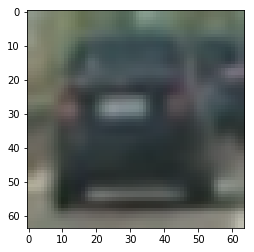

In [3]:
image = mpimg.imread('./vehicles/GTI_Far/image0002.png')
# img = np.uint8(image*255)
print("image shape {}".format(image.shape))
plot(image)

In [4]:
car_images = []
vehicle_dir = os.listdir("./vehicles/")
del vehicle_dir[0]
for path_dir in vehicle_dir:
    car_images.extend(glob.glob('./vehicles/'+ path_dir +'/*.png'))
    
not_car_images = []
non_vehicle_dir = os.listdir("./non-vehicles/")
del non_vehicle_dir[0]
for path_dir in non_vehicle_dir:
    not_car_images.extend(glob.glob('./non-vehicles/'+ path_dir +'/*.png'))

cars = []
notcars = []

for image in car_images:
    cars.append(image)
for image in not_car_images:
    notcars.append(image)
    
print("Number of cars is {}".format(len(cars)))
print("Number of not cars is {}".format(len(notcars)))

Number of cars is 8792
Number of not cars is 8968


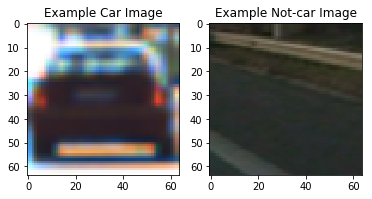

In [5]:
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

In [7]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        show=True, feature_vec=False)

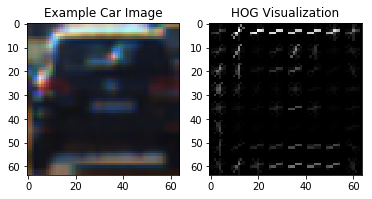

In [8]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

In [9]:
print(features.shape)

(7, 7, 2, 2, 9)


In [12]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        show=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, show=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [13]:
# sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size=(16, 16)
hist_bins=32,

t=time.time()
car_features = extract_features(cars, spatial_size=spatial_size,
                        hist_bins=hist_bins, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars,spatial_size=spatial_size,
                        hist_bins=hist_bins,color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

94.35 Seconds to extract HOG features...


In [14]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=1.0)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6060
7.06 Seconds to train SVC...
Test Accuracy of SVC =  0.9901
My SVC predicts:  [ 1.  0.  1.  1.  0.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  1.  1.  0.  0.  1.  0.  1.  1.]
0.01302 Seconds to predict 10 labels with SVC


In [15]:
pickle_file = 'Classifier.p'
print('Saving data to pickle file...')
with open(pickle_file, 'wb') as pfile:
    pickle.dump(
        {   'svc':svc, 
            'X_scaler': X_scaler,
            'color_space': colorspace,
            'spatial_size': spatial_size,
            'hist_bins': hist_bins,
            'orient': orient,
            'pix_per_cell': pix_per_cell,
            'cell_per_block': cell_per_block,
            'hog_channel': hog_channel,
#             'spatial_feat': spatial_feat,
#             'hist_feat': hist_feat,
#             'hog_feat':hog_feat
        },
        pfile, pickle.HIGHEST_PROTOCOL)
print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


In [16]:
dist_pickle = pickle.load( open("classifier.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
colorspace = dist_pickle["color_space"]

In [17]:
img = mpimg.imread('test_images/test3.jpg')

In [72]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show=False):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    hot_windows = []
    windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell+15
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
            
            if test_prediction == 1:
#                 xbox_left = np.int(xleft*scale)
#                 ytop_draw = np.int(ytop*scale)
#                 win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                hot_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    if show:
        return draw_img
    else:
        return hot_windows, windows
                
    return draw_img

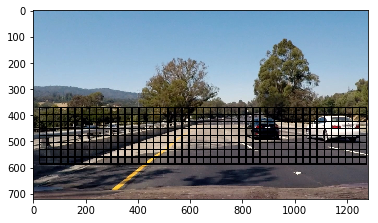

In [73]:
img = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(img)
ystart = 370
ystop = 620
scale = 1.7
    
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show=True)
windows, all_win = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
window_img = draw_boxes(draw_image, all_win, color=(0, 0, 1), thick=4)                    
plt.imshow(window_img)

# plt.imshow(out_img)
plt.show()

In [76]:
def search_scales(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show=False):
    ystart = [370, 360, 360]
    ystop = [500, 580, 620]
    scale = [1.2, 1.4, 1.7]
    draw_image = np.copy(img)
    all_windows = []
    hot_windows = []
    for i in range(len(scale)):
        hot_win, win = find_cars(img, ystart[i], ystop[i], scale[i], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        all_windows.extend(win)
        hot_windows.extend(hot_win)
        if show:
            window_img = draw_boxes(draw_image, win, color=(20*i, 5*i, i*30), thick=4)  
            plt.imshow(window_img)
            plt.show()
    print("total window searched is {}".format(len(all_windows)))
    print("total hot window found is {}".format(len(hot_windows)))
    if show:
        plt.show()
    return hot_windows

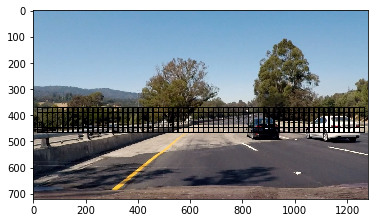

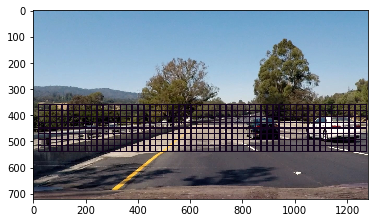

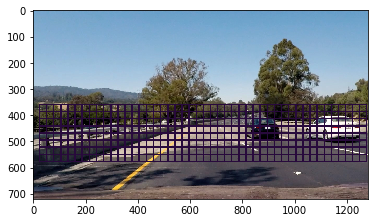

total window searched is 604
total hot window found is 37


In [77]:
hots = search_scales(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show=True)

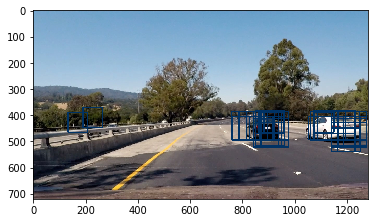

In [78]:
window_img = draw_boxes(img, hots, color=(0, 50, 100), thick=4)                    
plt.imshow(window_img)
plt.show()

In [79]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        print(img.shape[1])
        bbox = ((np.max((0, np.min(nonzerox)-18)), np.max((np.min(nonzeroy)-18,0))), (np.min((np.max(nonzerox)+8, img.shape[1]-1)), 
          np.min((np.max(nonzeroy)+8, img.shape[0]-1))))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [80]:
def add_heat(heatmap, bbox_list):
    """ get a heatmap of search windows classified as vehicle
        @param:
            heatmap: empty template
            bbox_list: found windows
        @output:
            heatmap
    """
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap
    
def apply_threshold(heatmap, threshold):
    """ zero out pixels below threshold
    """
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    """ draw rectangle for each car founded
        @param:
            labels: tuples,first contains the array of labeled data, second is the number of features
        @output:
            image with cars boxes drawed
    """
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # manually add or subtract some pixels form the value because I used larger threshold, and there are less boxes contain the margin 
        # by addition and subtraction we can get a better view
        bbox = ((np.max((0, np.min(nonzerox)-25)), np.max((np.min(nonzeroy)-5,0))), (np.min((np.max(nonzerox)+10, img.shape[1]-1)), 
          np.min((np.max(nonzeroy)+5, img.shape[0]-1))))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

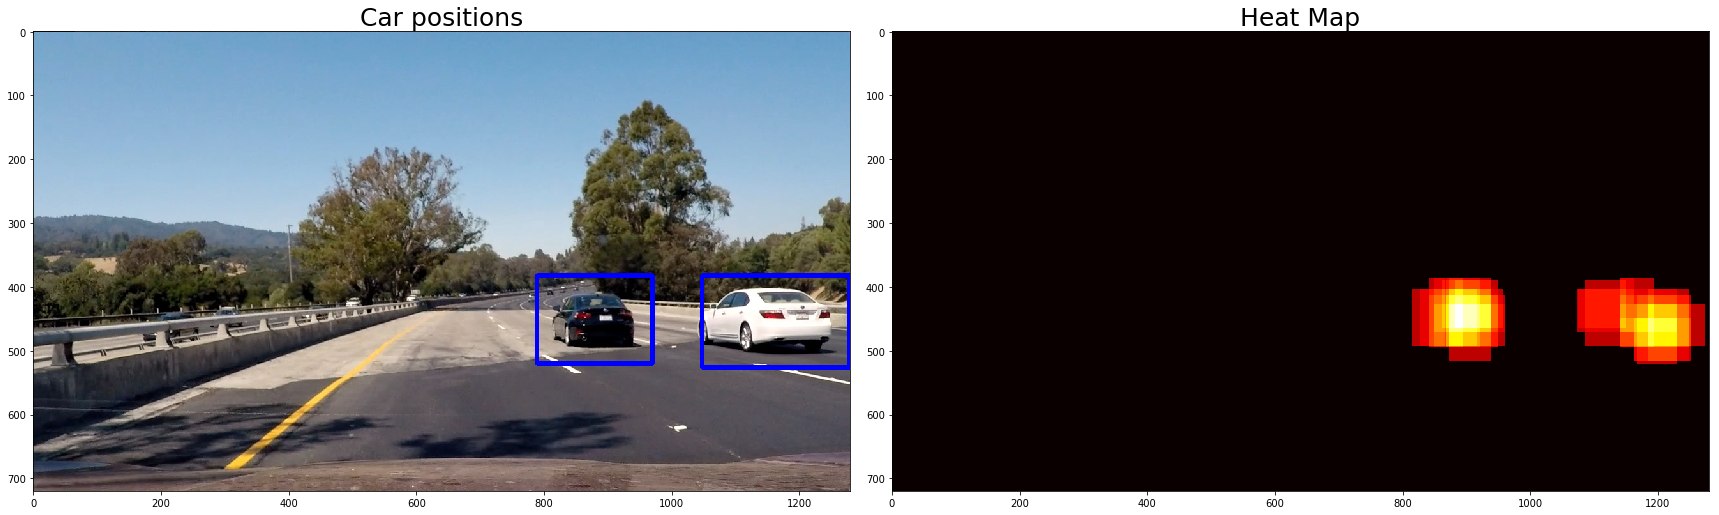

In [81]:
heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat,hots)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heat)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

plot_dual(draw_img, heatmap,'Car positions','Heat Map',cm2='hot')

In [84]:
class Tracker(object):
    def __init__(self, n_frames = 6):
        self.n_frames = n_frames
        self.boxes = []
        self.lengths = []
        
        self.dist_pickle = pickle.load( open("classifier.p", "rb" ) )
        self.svc = self.dist_pickle["svc"]
        self.X_scaler = self.dist_pickle["X_scaler"]
        self.orient = self.dist_pickle["orient"]
        self.pix_per_cell = self.dist_pickle["pix_per_cell"]
        self.cell_per_block = self.dist_pickle["cell_per_block"]
        self.spatial_size = self.dist_pickle["spatial_size"]
        self.hist_bins = self.dist_pickle["hist_bins"]
        self.colorspace = self.dist_pickle["color_space"]
        
        
        
    def update(self, new_boxes):
        if len(self.lengths) > self.n_frames:
            del self.boxes[0:self.lengths[0]]
            del self.lengths[0]
        self.lengths.append(len(new_boxes))
        self.boxes.extend(new_boxes)
        
    def detect(self, img, thresh_hold, show=False):
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = add_heat(heat,self.boxes)
        
        thresh = thresh_hold*len(self.lengths)
        if len(self.lengths) == 0:
            thresh = thresh_hold
#         if len(self.lengths) >= 3:
#             thresh -= thresh_hold
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,thresh)

        # Visualize the heatmap when displaying
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
        if show:
            plot_dual(draw_img, heatmap,'Car positions','Heat Map',cm2='hot')
        return draw_img
    
    def process_image(self, img):
#         plt.imshow(img)
#         plt.show()
        draw_image = np.copy(img)
        hots = search_scales(img,self.svc, self.X_scaler, self.orient, 
                             self.pix_per_cell, self.cell_per_block, self.spatial_size, self.hist_bins)
        self.update(hots)
        window_image = self.detect(img, 2)
#         plt.imshow(window_image)
#         plt.show()
        #window_image = draw_boxes(draw_image, hot_windows, color=(0,0,255), thick=6)
        return window_image

In [85]:
tracker = Tracker(6)

In [86]:
out_dir='./output_images/'
inpfile='project_video.mp4'
outfile=out_dir+'processed_'+inpfile
clip = VideoFileClip(inpfile)
out_clip = clip.fl_image(tracker.process_image) 
%time out_clip.write_videofile(outfile, audio=False)

total window searched is 604
total hot window found is 0
[MoviePy] >>>> Building video ./output_images/processed_project_video.mp4
[MoviePy] Writing video ./output_images/processed_project_video.mp4



  0%|          | 1/1261 [00:01<21:38,  1.03s/it]

total window searched is 604
total hot window found is 0



  0%|          | 2/1261 [00:02<21:40,  1.03s/it]

total window searched is 604
total hot window found is 1



  0%|          | 3/1261 [00:03<21:45,  1.04s/it]

total window searched is 604
total hot window found is 2



  0%|          | 4/1261 [00:04<21:45,  1.04s/it]

total window searched is 604
total hot window found is 1



  0%|          | 5/1261 [00:05<21:49,  1.04s/it]

total window searched is 604
total hot window found is 4



  0%|          | 6/1261 [00:06<21:58,  1.05s/it]

total window searched is 604
total hot window found is 2



  1%|          | 7/1261 [00:08<28:20,  1.36s/it]

total window searched is 604
total hot window found is 2



  1%|          | 8/1261 [00:13<50:59,  2.44s/it]

total window searched is 604
total hot window found is 1



  1%|          | 9/1261 [00:15<50:57,  2.44s/it]

total window searched is 604
total hot window found is 2



  1%|          | 10/1261 [00:16<43:21,  2.08s/it]

total window searched is 604
total hot window found is 1



  1%|          | 11/1261 [00:18<37:05,  1.78s/it]

total window searched is 604
total hot window found is 3



  1%|          | 12/1261 [00:19<32:43,  1.57s/it]

total window searched is 604
total hot window found is 2



  1%|          | 13/1261 [00:20<29:21,  1.41s/it]

total window searched is 604
total hot window found is 2



  1%|          | 14/1261 [00:21<27:26,  1.32s/it]

total window searched is 604
total hot window found is 3



  1%|          | 15/1261 [00:22<26:42,  1.29s/it]

total window searched is 604
total hot window found is 3



  1%|▏         | 16/1261 [00:23<26:16,  1.27s/it]

total window searched is 604
total hot window found is 2



  1%|▏         | 17/1261 [00:24<25:25,  1.23s/it]

total window searched is 604
total hot window found is 2



  1%|▏         | 18/1261 [00:25<24:37,  1.19s/it]

total window searched is 604
total hot window found is 1



  2%|▏         | 19/1261 [00:27<26:41,  1.29s/it]

total window searched is 604
total hot window found is 0



  2%|▏         | 20/1261 [00:29<32:37,  1.58s/it]

total window searched is 604
total hot window found is 0



  2%|▏         | 21/1261 [00:31<32:51,  1.59s/it]

total window searched is 604
total hot window found is 0



  2%|▏         | 22/1261 [00:32<29:31,  1.43s/it]

total window searched is 604
total hot window found is 0



  2%|▏         | 23/1261 [00:33<27:13,  1.32s/it]

total window searched is 604
total hot window found is 0



  2%|▏         | 24/1261 [00:34<26:05,  1.27s/it]

total window searched is 604
total hot window found is 0



  2%|▏         | 25/1261 [00:35<24:54,  1.21s/it]

total window searched is 604
total hot window found is 2



  2%|▏         | 26/1261 [00:36<23:40,  1.15s/it]

total window searched is 604
total hot window found is 2



  2%|▏         | 27/1261 [00:37<23:11,  1.13s/it]

total window searched is 604
total hot window found is 3



  2%|▏         | 28/1261 [00:38<22:43,  1.11s/it]

total window searched is 604
total hot window found is 3



  2%|▏         | 29/1261 [00:39<22:23,  1.09s/it]

total window searched is 604
total hot window found is 3



  2%|▏         | 30/1261 [00:40<22:11,  1.08s/it]

total window searched is 604
total hot window found is 0



  2%|▏         | 31/1261 [00:42<22:11,  1.08s/it]

total window searched is 604
total hot window found is 2



  3%|▎         | 32/1261 [00:43<21:57,  1.07s/it]

total window searched is 604
total hot window found is 0



  3%|▎         | 33/1261 [00:44<21:42,  1.06s/it]

total window searched is 604
total hot window found is 2



  3%|▎         | 34/1261 [00:45<22:08,  1.08s/it]

total window searched is 604
total hot window found is 1



  3%|▎         | 35/1261 [00:46<21:51,  1.07s/it]

total window searched is 604
total hot window found is 4



  3%|▎         | 36/1261 [00:47<22:11,  1.09s/it]

total window searched is 604
total hot window found is 1



  3%|▎         | 37/1261 [00:49<26:29,  1.30s/it]

total window searched is 604
total hot window found is 2



  3%|▎         | 38/1261 [00:50<25:19,  1.24s/it]

total window searched is 604
total hot window found is 3



  3%|▎         | 39/1261 [00:51<25:03,  1.23s/it]

total window searched is 604
total hot window found is 5



  3%|▎         | 40/1261 [00:52<24:40,  1.21s/it]

total window searched is 604
total hot window found is 1



  3%|▎         | 41/1261 [00:53<24:22,  1.20s/it]

total window searched is 604
total hot window found is 3



  3%|▎         | 42/1261 [00:54<23:49,  1.17s/it]

total window searched is 604
total hot window found is 4



  3%|▎         | 43/1261 [00:56<23:48,  1.17s/it]

total window searched is 604
total hot window found is 0



  3%|▎         | 44/1261 [00:57<23:17,  1.15s/it]

total window searched is 604
total hot window found is 0



  4%|▎         | 45/1261 [00:58<23:09,  1.14s/it]

total window searched is 604
total hot window found is 0



  4%|▎         | 46/1261 [00:59<24:51,  1.23s/it]

total window searched is 604
total hot window found is 0



  4%|▎         | 47/1261 [01:01<24:46,  1.22s/it]

total window searched is 604
total hot window found is 0



  4%|▍         | 48/1261 [01:02<24:26,  1.21s/it]

total window searched is 604
total hot window found is 0



  4%|▍         | 49/1261 [01:03<23:52,  1.18s/it]

total window searched is 604
total hot window found is 1



  4%|▍         | 50/1261 [01:04<23:29,  1.16s/it]

total window searched is 604
total hot window found is 1



  4%|▍         | 51/1261 [01:05<23:05,  1.15s/it]

total window searched is 604
total hot window found is 1



  4%|▍         | 52/1261 [01:06<23:40,  1.17s/it]

total window searched is 604
total hot window found is 0



  4%|▍         | 53/1261 [01:08<24:55,  1.24s/it]

total window searched is 604
total hot window found is 1



  4%|▍         | 54/1261 [01:09<24:41,  1.23s/it]

total window searched is 604
total hot window found is 0



  4%|▍         | 55/1261 [01:10<24:08,  1.20s/it]

total window searched is 604
total hot window found is 1



  4%|▍         | 56/1261 [01:11<23:34,  1.17s/it]

total window searched is 604
total hot window found is 1



  5%|▍         | 57/1261 [01:12<23:17,  1.16s/it]

total window searched is 604
total hot window found is 1



  5%|▍         | 58/1261 [01:13<22:58,  1.15s/it]

total window searched is 604
total hot window found is 1



  5%|▍         | 59/1261 [01:15<26:52,  1.34s/it]

total window searched is 604
total hot window found is 1



  5%|▍         | 60/1261 [01:16<24:50,  1.24s/it]

total window searched is 604
total hot window found is 0



  5%|▍         | 61/1261 [01:17<23:33,  1.18s/it]

total window searched is 604
total hot window found is 0



  5%|▍         | 62/1261 [01:18<22:44,  1.14s/it]

total window searched is 604
total hot window found is 0



  5%|▍         | 63/1261 [01:19<22:05,  1.11s/it]

total window searched is 604
total hot window found is 0



  5%|▌         | 64/1261 [01:20<21:23,  1.07s/it]

total window searched is 604
total hot window found is 0



  5%|▌         | 65/1261 [01:21<20:52,  1.05s/it]

total window searched is 604
total hot window found is 0



  5%|▌         | 66/1261 [01:22<20:28,  1.03s/it]

total window searched is 604
total hot window found is 0



  5%|▌         | 67/1261 [01:23<20:04,  1.01s/it]

total window searched is 604
total hot window found is 0



  5%|▌         | 68/1261 [01:24<19:47,  1.00it/s]

total window searched is 604
total hot window found is 0



  5%|▌         | 69/1261 [01:25<20:29,  1.03s/it]

total window searched is 604
total hot window found is 0



  6%|▌         | 70/1261 [01:26<20:06,  1.01s/it]

total window searched is 604
total hot window found is 0



  6%|▌         | 71/1261 [01:27<20:06,  1.01s/it]

total window searched is 604
total hot window found is 0



  6%|▌         | 72/1261 [01:28<21:18,  1.07s/it]

total window searched is 604
total hot window found is 0



  6%|▌         | 73/1261 [01:30<20:58,  1.06s/it]

total window searched is 604
total hot window found is 0



  6%|▌         | 74/1261 [01:31<20:49,  1.05s/it]

total window searched is 604
total hot window found is 0



  6%|▌         | 75/1261 [01:32<21:02,  1.06s/it]

total window searched is 604
total hot window found is 0



  6%|▌         | 76/1261 [01:33<21:14,  1.08s/it]

total window searched is 604
total hot window found is 0



  6%|▌         | 77/1261 [01:34<21:56,  1.11s/it]

total window searched is 604
total hot window found is 0



  6%|▌         | 78/1261 [01:35<22:14,  1.13s/it]

total window searched is 604
total hot window found is 0



  6%|▋         | 79/1261 [01:36<22:06,  1.12s/it]

total window searched is 604
total hot window found is 0



  6%|▋         | 80/1261 [01:37<21:19,  1.08s/it]

total window searched is 604
total hot window found is 0



  6%|▋         | 81/1261 [01:38<21:16,  1.08s/it]

total window searched is 604
total hot window found is 0



  7%|▋         | 82/1261 [01:39<21:13,  1.08s/it]

total window searched is 604
total hot window found is 0



  7%|▋         | 83/1261 [01:40<21:06,  1.08s/it]

total window searched is 604
total hot window found is 0



  7%|▋         | 84/1261 [01:42<21:09,  1.08s/it]

total window searched is 604
total hot window found is 0



  7%|▋         | 85/1261 [01:43<20:52,  1.07s/it]

total window searched is 604
total hot window found is 0



  7%|▋         | 86/1261 [01:44<20:46,  1.06s/it]

total window searched is 604
total hot window found is 0



  7%|▋         | 87/1261 [01:45<20:46,  1.06s/it]

total window searched is 604
total hot window found is 0



  7%|▋         | 88/1261 [01:46<20:42,  1.06s/it]

total window searched is 604
total hot window found is 0



  7%|▋         | 89/1261 [01:47<23:01,  1.18s/it]

total window searched is 604
total hot window found is 0



  7%|▋         | 90/1261 [01:48<22:14,  1.14s/it]

total window searched is 604
total hot window found is 0



  7%|▋         | 91/1261 [01:49<21:26,  1.10s/it]

total window searched is 604
total hot window found is 0



  7%|▋         | 92/1261 [01:50<20:59,  1.08s/it]

total window searched is 604
total hot window found is 0



  7%|▋         | 93/1261 [01:51<20:37,  1.06s/it]

total window searched is 604
total hot window found is 0



  7%|▋         | 94/1261 [01:52<20:24,  1.05s/it]

total window searched is 604
total hot window found is 0



  8%|▊         | 95/1261 [01:54<23:11,  1.19s/it]

total window searched is 604
total hot window found is 0



  8%|▊         | 96/1261 [01:55<22:58,  1.18s/it]

total window searched is 604
total hot window found is 0



  8%|▊         | 97/1261 [01:56<22:15,  1.15s/it]

total window searched is 604
total hot window found is 0



  8%|▊         | 98/1261 [01:57<21:51,  1.13s/it]

total window searched is 604
total hot window found is 0



  8%|▊         | 99/1261 [01:58<21:07,  1.09s/it]

total window searched is 604
total hot window found is 0



  8%|▊         | 100/1261 [01:59<20:56,  1.08s/it]

total window searched is 604
total hot window found is 0



  8%|▊         | 101/1261 [02:00<20:30,  1.06s/it]

total window searched is 604
total hot window found is 0



  8%|▊         | 102/1261 [02:01<20:10,  1.04s/it]

total window searched is 604
total hot window found is 0



  8%|▊         | 103/1261 [02:02<19:48,  1.03s/it]

total window searched is 604
total hot window found is 1



  8%|▊         | 104/1261 [02:03<20:00,  1.04s/it]

total window searched is 604
total hot window found is 0



  8%|▊         | 105/1261 [02:04<19:46,  1.03s/it]

total window searched is 604
total hot window found is 0



  8%|▊         | 106/1261 [02:05<19:24,  1.01s/it]

total window searched is 604
total hot window found is 0



  8%|▊         | 107/1261 [02:06<19:07,  1.01it/s]

total window searched is 604
total hot window found is 1



  9%|▊         | 108/1261 [02:07<19:04,  1.01it/s]

total window searched is 604
total hot window found is 0



  9%|▊         | 109/1261 [02:08<19:05,  1.01it/s]

total window searched is 604
total hot window found is 0



  9%|▊         | 110/1261 [02:09<18:54,  1.01it/s]

total window searched is 604
total hot window found is 0



  9%|▉         | 111/1261 [02:10<18:51,  1.02it/s]

total window searched is 604
total hot window found is 0



  9%|▉         | 112/1261 [02:11<18:45,  1.02it/s]

total window searched is 604
total hot window found is 0



  9%|▉         | 113/1261 [02:12<18:41,  1.02it/s]

total window searched is 604
total hot window found is 0



  9%|▉         | 114/1261 [02:13<18:39,  1.02it/s]

total window searched is 604
total hot window found is 1



  9%|▉         | 115/1261 [02:14<18:37,  1.03it/s]

total window searched is 604
total hot window found is 2



  9%|▉         | 116/1261 [02:15<18:34,  1.03it/s]

total window searched is 604
total hot window found is 1



  9%|▉         | 117/1261 [02:16<18:46,  1.02it/s]

total window searched is 604
total hot window found is 2



  9%|▉         | 118/1261 [02:17<18:52,  1.01it/s]

total window searched is 604
total hot window found is 0



  9%|▉         | 119/1261 [02:18<19:00,  1.00it/s]

total window searched is 604
total hot window found is 2



 10%|▉         | 120/1261 [02:19<18:52,  1.01it/s]

total window searched is 604
total hot window found is 0



 10%|▉         | 121/1261 [02:20<18:51,  1.01it/s]

total window searched is 604
total hot window found is 0



 10%|▉         | 122/1261 [02:21<18:56,  1.00it/s]

total window searched is 604
total hot window found is 1



 10%|▉         | 123/1261 [02:22<18:57,  1.00it/s]

total window searched is 604
total hot window found is 0



 10%|▉         | 124/1261 [02:23<19:39,  1.04s/it]

total window searched is 604
total hot window found is 0



 10%|▉         | 125/1261 [02:25<23:02,  1.22s/it]

total window searched is 604
total hot window found is 0



 10%|▉         | 126/1261 [02:26<22:39,  1.20s/it]

total window searched is 604
total hot window found is 0



 10%|█         | 127/1261 [02:27<21:56,  1.16s/it]

total window searched is 604
total hot window found is 1



 10%|█         | 128/1261 [02:28<21:23,  1.13s/it]

total window searched is 604
total hot window found is 2



 10%|█         | 129/1261 [02:29<20:38,  1.09s/it]

total window searched is 604
total hot window found is 0



 10%|█         | 130/1261 [02:30<20:34,  1.09s/it]

total window searched is 604
total hot window found is 1



 10%|█         | 131/1261 [02:31<20:12,  1.07s/it]

total window searched is 604
total hot window found is 2



 10%|█         | 132/1261 [02:32<20:01,  1.06s/it]

total window searched is 604
total hot window found is 1



 11%|█         | 133/1261 [02:33<19:47,  1.05s/it]

total window searched is 604
total hot window found is 2



 11%|█         | 134/1261 [02:34<19:32,  1.04s/it]

total window searched is 604
total hot window found is 3



 11%|█         | 135/1261 [02:35<20:25,  1.09s/it]

total window searched is 604
total hot window found is 7



 11%|█         | 136/1261 [02:37<21:46,  1.16s/it]

total window searched is 604
total hot window found is 6



 11%|█         | 137/1261 [02:38<21:12,  1.13s/it]

total window searched is 604
total hot window found is 7



 11%|█         | 138/1261 [02:39<20:56,  1.12s/it]

total window searched is 604
total hot window found is 7



 11%|█         | 139/1261 [02:40<20:13,  1.08s/it]

total window searched is 604
total hot window found is 1



 11%|█         | 140/1261 [02:41<19:43,  1.06s/it]

total window searched is 604
total hot window found is 0



 11%|█         | 141/1261 [02:42<19:15,  1.03s/it]

total window searched is 604
total hot window found is 1



 11%|█▏        | 142/1261 [02:43<19:04,  1.02s/it]

total window searched is 604
total hot window found is 1



 11%|█▏        | 143/1261 [02:44<18:48,  1.01s/it]

total window searched is 604
total hot window found is 0



 11%|█▏        | 144/1261 [02:45<18:55,  1.02s/it]

total window searched is 604
total hot window found is 0



 11%|█▏        | 145/1261 [02:46<19:34,  1.05s/it]

total window searched is 604
total hot window found is 0



 12%|█▏        | 146/1261 [02:47<19:24,  1.04s/it]

total window searched is 604
total hot window found is 0



 12%|█▏        | 147/1261 [02:48<19:35,  1.06s/it]

total window searched is 604
total hot window found is 1



 12%|█▏        | 148/1261 [02:49<19:47,  1.07s/it]

total window searched is 604
total hot window found is 0



 12%|█▏        | 149/1261 [02:50<20:00,  1.08s/it]

total window searched is 604
total hot window found is 0



 12%|█▏        | 150/1261 [02:51<19:59,  1.08s/it]

total window searched is 604
total hot window found is 0



 12%|█▏        | 151/1261 [02:53<20:51,  1.13s/it]

total window searched is 604
total hot window found is 0



 12%|█▏        | 152/1261 [02:54<20:13,  1.09s/it]

total window searched is 604
total hot window found is 0



 12%|█▏        | 153/1261 [02:55<19:37,  1.06s/it]

total window searched is 604
total hot window found is 0



 12%|█▏        | 154/1261 [02:56<19:07,  1.04s/it]

total window searched is 604
total hot window found is 0



 12%|█▏        | 155/1261 [02:57<18:41,  1.01s/it]

total window searched is 604
total hot window found is 0



 12%|█▏        | 156/1261 [02:58<18:29,  1.00s/it]

total window searched is 604
total hot window found is 1



 12%|█▏        | 157/1261 [02:59<19:28,  1.06s/it]

total window searched is 604
total hot window found is 1



 13%|█▎        | 158/1261 [03:00<22:30,  1.22s/it]

total window searched is 604
total hot window found is 1



 13%|█▎        | 159/1261 [03:02<22:21,  1.22s/it]

total window searched is 604
total hot window found is 0



 13%|█▎        | 160/1261 [03:03<21:21,  1.16s/it]

total window searched is 604
total hot window found is 1



 13%|█▎        | 161/1261 [03:04<21:08,  1.15s/it]

total window searched is 604
total hot window found is 2



 13%|█▎        | 162/1261 [03:05<20:55,  1.14s/it]

total window searched is 604
total hot window found is 2



 13%|█▎        | 163/1261 [03:06<21:49,  1.19s/it]

total window searched is 604
total hot window found is 2



 13%|█▎        | 164/1261 [03:08<23:36,  1.29s/it]

total window searched is 604
total hot window found is 4



 13%|█▎        | 165/1261 [03:09<22:58,  1.26s/it]

total window searched is 604
total hot window found is 4



 13%|█▎        | 166/1261 [03:10<22:28,  1.23s/it]

total window searched is 604
total hot window found is 5



 13%|█▎        | 167/1261 [03:11<21:16,  1.17s/it]

total window searched is 604
total hot window found is 5



 13%|█▎        | 168/1261 [03:12<20:48,  1.14s/it]

total window searched is 604
total hot window found is 6



 13%|█▎        | 169/1261 [03:13<21:06,  1.16s/it]

total window searched is 604
total hot window found is 10



 13%|█▎        | 170/1261 [03:15<23:02,  1.27s/it]

total window searched is 604
total hot window found is 6



 14%|█▎        | 171/1261 [03:17<25:11,  1.39s/it]

total window searched is 604
total hot window found is 5



 14%|█▎        | 172/1261 [03:18<25:20,  1.40s/it]

total window searched is 604
total hot window found is 8



 14%|█▎        | 173/1261 [03:19<24:23,  1.34s/it]

total window searched is 604
total hot window found is 6



 14%|█▍        | 174/1261 [03:20<22:52,  1.26s/it]

total window searched is 604
total hot window found is 7



 14%|█▍        | 175/1261 [03:21<22:10,  1.23s/it]

total window searched is 604
total hot window found is 6



 14%|█▍        | 176/1261 [03:23<21:37,  1.20s/it]

total window searched is 604
total hot window found is 7



 14%|█▍        | 177/1261 [03:24<21:27,  1.19s/it]

total window searched is 604
total hot window found is 5



 14%|█▍        | 178/1261 [03:25<20:38,  1.14s/it]

total window searched is 604
total hot window found is 10



 14%|█▍        | 179/1261 [03:26<20:21,  1.13s/it]

total window searched is 604
total hot window found is 8



 14%|█▍        | 180/1261 [03:27<19:31,  1.08s/it]

total window searched is 604
total hot window found is 10



 14%|█▍        | 181/1261 [03:28<18:53,  1.05s/it]

total window searched is 604
total hot window found is 4



 14%|█▍        | 182/1261 [03:29<18:45,  1.04s/it]

total window searched is 604
total hot window found is 5



 15%|█▍        | 183/1261 [03:30<18:17,  1.02s/it]

total window searched is 604
total hot window found is 6



 15%|█▍        | 184/1261 [03:31<17:59,  1.00s/it]

total window searched is 604
total hot window found is 4



 15%|█▍        | 185/1261 [03:32<17:49,  1.01it/s]

total window searched is 604
total hot window found is 5



 15%|█▍        | 186/1261 [03:33<17:43,  1.01it/s]

total window searched is 604
total hot window found is 6



 15%|█▍        | 187/1261 [03:34<17:33,  1.02it/s]

total window searched is 604
total hot window found is 6



 15%|█▍        | 188/1261 [03:35<17:24,  1.03it/s]

total window searched is 604
total hot window found is 6



 15%|█▍        | 189/1261 [03:36<17:20,  1.03it/s]

total window searched is 604
total hot window found is 8



 15%|█▌        | 190/1261 [03:37<17:20,  1.03it/s]

total window searched is 604
total hot window found is 10



 15%|█▌        | 191/1261 [03:37<17:13,  1.04it/s]

total window searched is 604
total hot window found is 9



 15%|█▌        | 192/1261 [03:38<17:16,  1.03it/s]

total window searched is 604
total hot window found is 7



 15%|█▌        | 193/1261 [03:40<17:37,  1.01it/s]

total window searched is 604
total hot window found is 5



 15%|█▌        | 194/1261 [03:41<17:50,  1.00s/it]

total window searched is 604
total hot window found is 8



 15%|█▌        | 195/1261 [03:42<18:12,  1.02s/it]

total window searched is 604
total hot window found is 8



 16%|█▌        | 196/1261 [03:43<20:57,  1.18s/it]

total window searched is 604
total hot window found is 7



 16%|█▌        | 197/1261 [03:44<21:20,  1.20s/it]

total window searched is 604
total hot window found is 5



 16%|█▌        | 198/1261 [03:46<20:43,  1.17s/it]

total window searched is 604
total hot window found is 5



 16%|█▌        | 199/1261 [03:47<21:26,  1.21s/it]

total window searched is 604
total hot window found is 6



 16%|█▌        | 200/1261 [03:48<20:35,  1.16s/it]

total window searched is 604
total hot window found is 5



 16%|█▌        | 201/1261 [03:49<19:48,  1.12s/it]

total window searched is 604
total hot window found is 4



 16%|█▌        | 202/1261 [03:50<19:05,  1.08s/it]

total window searched is 604
total hot window found is 5



 16%|█▌        | 203/1261 [03:51<18:27,  1.05s/it]

total window searched is 604
total hot window found is 7



 16%|█▌        | 204/1261 [03:52<18:03,  1.03s/it]

total window searched is 604
total hot window found is 8



 16%|█▋        | 205/1261 [03:53<17:44,  1.01s/it]

total window searched is 604
total hot window found is 8



 16%|█▋        | 206/1261 [03:54<17:29,  1.01it/s]

total window searched is 604
total hot window found is 7



 16%|█▋        | 207/1261 [03:55<17:37,  1.00s/it]

total window searched is 604
total hot window found is 8



 16%|█▋        | 208/1261 [03:56<17:39,  1.01s/it]

total window searched is 604
total hot window found is 11



 17%|█▋        | 209/1261 [03:57<17:26,  1.01it/s]

total window searched is 604
total hot window found is 9



 17%|█▋        | 210/1261 [03:58<17:13,  1.02it/s]

total window searched is 604
total hot window found is 6



 17%|█▋        | 211/1261 [03:59<17:03,  1.03it/s]

total window searched is 604
total hot window found is 4



 17%|█▋        | 212/1261 [04:00<16:58,  1.03it/s]

total window searched is 604
total hot window found is 5



 17%|█▋        | 213/1261 [04:01<16:52,  1.03it/s]

total window searched is 604
total hot window found is 6



 17%|█▋        | 214/1261 [04:02<16:48,  1.04it/s]

total window searched is 604
total hot window found is 7



 17%|█▋        | 215/1261 [04:02<16:43,  1.04it/s]

total window searched is 604
total hot window found is 5



 17%|█▋        | 216/1261 [04:03<16:50,  1.03it/s]

total window searched is 604
total hot window found is 7



 17%|█▋        | 217/1261 [04:05<17:14,  1.01it/s]

total window searched is 604
total hot window found is 7



 17%|█▋        | 218/1261 [04:06<17:28,  1.01s/it]

total window searched is 604
total hot window found is 10



 17%|█▋        | 219/1261 [04:07<17:24,  1.00s/it]

total window searched is 604
total hot window found is 9



 17%|█▋        | 220/1261 [04:08<17:13,  1.01it/s]

total window searched is 604
total hot window found is 9



 18%|█▊        | 221/1261 [04:08<17:04,  1.01it/s]

total window searched is 604
total hot window found is 11



 18%|█▊        | 222/1261 [04:09<16:54,  1.02it/s]

total window searched is 604
total hot window found is 9



 18%|█▊        | 223/1261 [04:10<16:48,  1.03it/s]

total window searched is 604
total hot window found is 9



 18%|█▊        | 224/1261 [04:11<16:44,  1.03it/s]

total window searched is 604
total hot window found is 10



 18%|█▊        | 225/1261 [04:12<16:39,  1.04it/s]

total window searched is 604
total hot window found is 10



 18%|█▊        | 226/1261 [04:13<16:39,  1.04it/s]

total window searched is 604
total hot window found is 10



 18%|█▊        | 227/1261 [04:14<16:39,  1.03it/s]

total window searched is 604
total hot window found is 9



 18%|█▊        | 228/1261 [04:15<16:37,  1.04it/s]

total window searched is 604
total hot window found is 8



 18%|█▊        | 229/1261 [04:16<17:30,  1.02s/it]

total window searched is 604
total hot window found is 8



 18%|█▊        | 230/1261 [04:17<17:15,  1.00s/it]

total window searched is 604
total hot window found is 9



 18%|█▊        | 231/1261 [04:18<17:07,  1.00it/s]

total window searched is 604
total hot window found is 12



 18%|█▊        | 232/1261 [04:19<16:59,  1.01it/s]

total window searched is 604
total hot window found is 14



 18%|█▊        | 233/1261 [04:20<16:51,  1.02it/s]

total window searched is 604
total hot window found is 12



 19%|█▊        | 234/1261 [04:21<16:48,  1.02it/s]

total window searched is 604
total hot window found is 10



 19%|█▊        | 235/1261 [04:22<16:40,  1.03it/s]

total window searched is 604
total hot window found is 14



 19%|█▊        | 236/1261 [04:23<16:40,  1.02it/s]

total window searched is 604
total hot window found is 9



 19%|█▉        | 237/1261 [04:24<16:40,  1.02it/s]

total window searched is 604
total hot window found is 11



 19%|█▉        | 238/1261 [04:25<16:32,  1.03it/s]

total window searched is 604
total hot window found is 10



 19%|█▉        | 239/1261 [04:26<16:30,  1.03it/s]

total window searched is 604
total hot window found is 10



 19%|█▉        | 240/1261 [04:27<16:30,  1.03it/s]

total window searched is 604
total hot window found is 13



 19%|█▉        | 241/1261 [04:28<16:26,  1.03it/s]

total window searched is 604
total hot window found is 7



 19%|█▉        | 242/1261 [04:29<16:26,  1.03it/s]

total window searched is 604
total hot window found is 9



 19%|█▉        | 243/1261 [04:30<16:21,  1.04it/s]

total window searched is 604
total hot window found is 7



 19%|█▉        | 244/1261 [04:31<16:15,  1.04it/s]

total window searched is 604
total hot window found is 8



 19%|█▉        | 245/1261 [04:32<16:13,  1.04it/s]

total window searched is 604
total hot window found is 9



 20%|█▉        | 246/1261 [04:33<16:10,  1.05it/s]

total window searched is 604
total hot window found is 12



 20%|█▉        | 247/1261 [04:34<16:14,  1.04it/s]

total window searched is 604
total hot window found is 10



 20%|█▉        | 248/1261 [04:35<16:13,  1.04it/s]

total window searched is 604
total hot window found is 15



 20%|█▉        | 249/1261 [04:36<16:09,  1.04it/s]

total window searched is 604
total hot window found is 17



 20%|█▉        | 250/1261 [04:37<16:09,  1.04it/s]

total window searched is 604
total hot window found is 18



 20%|█▉        | 251/1261 [04:38<16:09,  1.04it/s]

total window searched is 604
total hot window found is 21



 20%|█▉        | 252/1261 [04:39<16:13,  1.04it/s]

total window searched is 604
total hot window found is 22



 20%|██        | 253/1261 [04:40<16:11,  1.04it/s]

total window searched is 604
total hot window found is 21



 20%|██        | 254/1261 [04:41<16:10,  1.04it/s]

total window searched is 604
total hot window found is 16



 20%|██        | 255/1261 [04:41<16:12,  1.03it/s]

total window searched is 604
total hot window found is 18



 20%|██        | 256/1261 [04:42<16:17,  1.03it/s]

total window searched is 604
total hot window found is 14



 20%|██        | 257/1261 [04:43<16:27,  1.02it/s]

total window searched is 604
total hot window found is 13



 20%|██        | 258/1261 [04:44<16:26,  1.02it/s]

total window searched is 604
total hot window found is 15



 21%|██        | 259/1261 [04:45<16:22,  1.02it/s]

total window searched is 604
total hot window found is 16



 21%|██        | 260/1261 [04:46<16:24,  1.02it/s]

total window searched is 604
total hot window found is 14



 21%|██        | 261/1261 [04:47<16:18,  1.02it/s]

total window searched is 604
total hot window found is 14



 21%|██        | 262/1261 [04:48<16:16,  1.02it/s]

total window searched is 604
total hot window found is 13



 21%|██        | 263/1261 [04:49<16:13,  1.03it/s]

total window searched is 604
total hot window found is 16



 21%|██        | 264/1261 [04:50<16:13,  1.02it/s]

total window searched is 604
total hot window found is 19



 21%|██        | 265/1261 [04:51<16:12,  1.02it/s]

total window searched is 604
total hot window found is 20



 21%|██        | 266/1261 [04:52<16:08,  1.03it/s]

total window searched is 604
total hot window found is 20



 21%|██        | 267/1261 [04:53<16:06,  1.03it/s]

total window searched is 604
total hot window found is 18



 21%|██▏       | 268/1261 [04:54<16:05,  1.03it/s]

total window searched is 604
total hot window found is 17



 21%|██▏       | 269/1261 [04:55<16:03,  1.03it/s]

total window searched is 604
total hot window found is 16



 21%|██▏       | 270/1261 [04:56<16:01,  1.03it/s]

total window searched is 604
total hot window found is 16



 21%|██▏       | 271/1261 [04:57<15:55,  1.04it/s]

total window searched is 604
total hot window found is 8



 22%|██▏       | 272/1261 [04:58<15:58,  1.03it/s]

total window searched is 604
total hot window found is 13



 22%|██▏       | 273/1261 [04:59<15:56,  1.03it/s]

total window searched is 604
total hot window found is 14



 22%|██▏       | 274/1261 [05:00<15:54,  1.03it/s]

total window searched is 604
total hot window found is 15



 22%|██▏       | 275/1261 [05:01<15:53,  1.03it/s]

total window searched is 604
total hot window found is 18



 22%|██▏       | 276/1261 [05:02<15:52,  1.03it/s]

total window searched is 604
total hot window found is 16



 22%|██▏       | 277/1261 [05:03<15:53,  1.03it/s]

total window searched is 604
total hot window found is 14



 22%|██▏       | 278/1261 [05:04<15:49,  1.03it/s]

total window searched is 604
total hot window found is 18



 22%|██▏       | 279/1261 [05:05<15:48,  1.04it/s]

total window searched is 604
total hot window found is 19



 22%|██▏       | 280/1261 [05:06<15:45,  1.04it/s]

total window searched is 604
total hot window found is 16



 22%|██▏       | 281/1261 [05:07<16:19,  1.00it/s]

total window searched is 604
total hot window found is 15



 22%|██▏       | 282/1261 [05:08<17:05,  1.05s/it]

total window searched is 604
total hot window found is 15



 22%|██▏       | 283/1261 [05:09<19:04,  1.17s/it]

total window searched is 604
total hot window found is 14



 23%|██▎       | 284/1261 [05:11<21:54,  1.35s/it]

total window searched is 604
total hot window found is 16



 23%|██▎       | 285/1261 [05:13<23:27,  1.44s/it]

total window searched is 604
total hot window found is 15



 23%|██▎       | 286/1261 [05:14<23:02,  1.42s/it]

total window searched is 604
total hot window found is 16



 23%|██▎       | 287/1261 [05:16<22:16,  1.37s/it]

total window searched is 604
total hot window found is 16



 23%|██▎       | 288/1261 [05:17<20:58,  1.29s/it]

total window searched is 604
total hot window found is 14



 23%|██▎       | 289/1261 [05:18<19:52,  1.23s/it]

total window searched is 604
total hot window found is 17



 23%|██▎       | 290/1261 [05:19<19:01,  1.18s/it]

total window searched is 604
total hot window found is 16



 23%|██▎       | 291/1261 [05:20<18:43,  1.16s/it]

total window searched is 604
total hot window found is 16



 23%|██▎       | 292/1261 [05:21<18:35,  1.15s/it]

total window searched is 604
total hot window found is 14



 23%|██▎       | 293/1261 [05:22<17:57,  1.11s/it]

total window searched is 604
total hot window found is 17



 23%|██▎       | 294/1261 [05:23<19:30,  1.21s/it]

total window searched is 604
total hot window found is 16



 23%|██▎       | 295/1261 [05:25<20:50,  1.29s/it]

total window searched is 604
total hot window found is 17



 23%|██▎       | 296/1261 [05:26<21:28,  1.33s/it]

total window searched is 604
total hot window found is 17



 24%|██▎       | 297/1261 [05:28<20:22,  1.27s/it]

total window searched is 604
total hot window found is 17



 24%|██▎       | 298/1261 [05:29<19:23,  1.21s/it]

total window searched is 604
total hot window found is 17



 24%|██▎       | 299/1261 [05:30<18:42,  1.17s/it]

total window searched is 604
total hot window found is 17



 24%|██▍       | 300/1261 [05:31<19:47,  1.24s/it]

total window searched is 604
total hot window found is 15



 24%|██▍       | 301/1261 [05:32<18:50,  1.18s/it]

total window searched is 604
total hot window found is 10



 24%|██▍       | 302/1261 [05:33<17:57,  1.12s/it]

total window searched is 604
total hot window found is 13



 24%|██▍       | 303/1261 [05:34<17:26,  1.09s/it]

total window searched is 604
total hot window found is 16



 24%|██▍       | 304/1261 [05:35<16:59,  1.07s/it]

total window searched is 604
total hot window found is 14



 24%|██▍       | 305/1261 [05:36<16:45,  1.05s/it]

total window searched is 604
total hot window found is 17



 24%|██▍       | 306/1261 [05:37<16:46,  1.05s/it]

total window searched is 604
total hot window found is 15



 24%|██▍       | 307/1261 [05:38<16:35,  1.04s/it]

total window searched is 604
total hot window found is 17



 24%|██▍       | 308/1261 [05:39<16:26,  1.04s/it]

total window searched is 604
total hot window found is 17



 25%|██▍       | 309/1261 [05:40<16:32,  1.04s/it]

total window searched is 604
total hot window found is 18



 25%|██▍       | 310/1261 [05:41<16:26,  1.04s/it]

total window searched is 604
total hot window found is 18



 25%|██▍       | 311/1261 [05:42<16:15,  1.03s/it]

total window searched is 604
total hot window found is 17



 25%|██▍       | 312/1261 [05:43<16:12,  1.02s/it]

total window searched is 604
total hot window found is 18



 25%|██▍       | 313/1261 [05:44<16:12,  1.03s/it]

total window searched is 604
total hot window found is 20



 25%|██▍       | 314/1261 [05:45<16:15,  1.03s/it]

total window searched is 604
total hot window found is 17



 25%|██▍       | 315/1261 [05:46<16:15,  1.03s/it]

total window searched is 604
total hot window found is 18



 25%|██▌       | 316/1261 [05:47<16:13,  1.03s/it]

total window searched is 604
total hot window found is 15



 25%|██▌       | 317/1261 [05:48<16:13,  1.03s/it]

total window searched is 604
total hot window found is 21



 25%|██▌       | 318/1261 [05:50<16:12,  1.03s/it]

total window searched is 604
total hot window found is 17



 25%|██▌       | 319/1261 [05:51<16:15,  1.04s/it]

total window searched is 604
total hot window found is 20



 25%|██▌       | 320/1261 [05:52<16:21,  1.04s/it]

total window searched is 604
total hot window found is 14



 25%|██▌       | 321/1261 [05:53<16:15,  1.04s/it]

total window searched is 604
total hot window found is 17



 26%|██▌       | 322/1261 [05:54<16:11,  1.03s/it]

total window searched is 604
total hot window found is 15



 26%|██▌       | 323/1261 [05:55<16:16,  1.04s/it]

total window searched is 604
total hot window found is 16



 26%|██▌       | 324/1261 [05:56<16:13,  1.04s/it]

total window searched is 604
total hot window found is 14



 26%|██▌       | 325/1261 [05:57<16:07,  1.03s/it]

total window searched is 604
total hot window found is 14



 26%|██▌       | 326/1261 [05:58<16:07,  1.04s/it]

total window searched is 604
total hot window found is 16



 26%|██▌       | 327/1261 [05:59<16:05,  1.03s/it]

total window searched is 604
total hot window found is 15



 26%|██▌       | 328/1261 [06:00<17:06,  1.10s/it]

total window searched is 604
total hot window found is 17



 26%|██▌       | 329/1261 [06:01<17:12,  1.11s/it]

total window searched is 604
total hot window found is 15



 26%|██▌       | 330/1261 [06:02<17:14,  1.11s/it]

total window searched is 604
total hot window found is 16



 26%|██▌       | 331/1261 [06:03<17:08,  1.11s/it]

total window searched is 604
total hot window found is 8



 26%|██▋       | 332/1261 [06:05<16:58,  1.10s/it]

total window searched is 604
total hot window found is 12



 26%|██▋       | 333/1261 [06:06<20:12,  1.31s/it]

total window searched is 604
total hot window found is 13



 26%|██▋       | 334/1261 [06:07<18:55,  1.22s/it]

total window searched is 604
total hot window found is 15



 27%|██▋       | 335/1261 [06:08<18:01,  1.17s/it]

total window searched is 604
total hot window found is 15



 27%|██▋       | 336/1261 [06:09<17:22,  1.13s/it]

total window searched is 604
total hot window found is 11



 27%|██▋       | 337/1261 [06:10<17:02,  1.11s/it]

total window searched is 604
total hot window found is 12



 27%|██▋       | 338/1261 [06:12<16:43,  1.09s/it]

total window searched is 604
total hot window found is 18



 27%|██▋       | 339/1261 [06:13<16:17,  1.06s/it]

total window searched is 604
total hot window found is 13



 27%|██▋       | 340/1261 [06:14<16:00,  1.04s/it]

total window searched is 604
total hot window found is 11



 27%|██▋       | 341/1261 [06:15<15:50,  1.03s/it]

total window searched is 604
total hot window found is 12



 27%|██▋       | 342/1261 [06:16<15:46,  1.03s/it]

total window searched is 604
total hot window found is 11



 27%|██▋       | 343/1261 [06:17<16:12,  1.06s/it]

total window searched is 604
total hot window found is 16



 27%|██▋       | 344/1261 [06:18<16:12,  1.06s/it]

total window searched is 604
total hot window found is 17



 27%|██▋       | 345/1261 [06:19<16:01,  1.05s/it]

total window searched is 604
total hot window found is 14



 27%|██▋       | 346/1261 [06:20<15:54,  1.04s/it]

total window searched is 604
total hot window found is 13



 28%|██▊       | 347/1261 [06:21<15:55,  1.04s/it]

total window searched is 604
total hot window found is 15



 28%|██▊       | 348/1261 [06:22<15:55,  1.05s/it]

total window searched is 604
total hot window found is 15



 28%|██▊       | 349/1261 [06:23<15:57,  1.05s/it]

total window searched is 604
total hot window found is 14



 28%|██▊       | 350/1261 [06:24<15:52,  1.05s/it]

total window searched is 604
total hot window found is 17



 28%|██▊       | 351/1261 [06:25<15:45,  1.04s/it]

total window searched is 604
total hot window found is 14



 28%|██▊       | 352/1261 [06:26<15:50,  1.05s/it]

total window searched is 604
total hot window found is 10



 28%|██▊       | 353/1261 [06:27<15:40,  1.04s/it]

total window searched is 604
total hot window found is 11



 28%|██▊       | 354/1261 [06:28<15:28,  1.02s/it]

total window searched is 604
total hot window found is 11



 28%|██▊       | 355/1261 [06:29<15:26,  1.02s/it]

total window searched is 604
total hot window found is 11



 28%|██▊       | 356/1261 [06:30<15:30,  1.03s/it]

total window searched is 604
total hot window found is 13



 28%|██▊       | 357/1261 [06:31<16:46,  1.11s/it]

total window searched is 604
total hot window found is 15



 28%|██▊       | 358/1261 [06:33<18:35,  1.24s/it]

total window searched is 604
total hot window found is 10



 28%|██▊       | 359/1261 [06:34<18:02,  1.20s/it]

total window searched is 604
total hot window found is 10



 29%|██▊       | 360/1261 [06:35<17:30,  1.17s/it]

total window searched is 604
total hot window found is 14



 29%|██▊       | 361/1261 [06:36<16:55,  1.13s/it]

total window searched is 604
total hot window found is 8



 29%|██▊       | 362/1261 [06:37<16:32,  1.10s/it]

total window searched is 604
total hot window found is 8



 29%|██▉       | 363/1261 [06:38<16:12,  1.08s/it]

total window searched is 604
total hot window found is 9



 29%|██▉       | 364/1261 [06:39<16:04,  1.08s/it]

total window searched is 604
total hot window found is 7



 29%|██▉       | 365/1261 [06:40<15:53,  1.06s/it]

total window searched is 604
total hot window found is 12



 29%|██▉       | 366/1261 [06:41<15:48,  1.06s/it]

total window searched is 604
total hot window found is 12



 29%|██▉       | 367/1261 [06:43<15:44,  1.06s/it]

total window searched is 604
total hot window found is 12



 29%|██▉       | 368/1261 [06:44<15:42,  1.06s/it]

total window searched is 604
total hot window found is 13



 29%|██▉       | 369/1261 [06:45<15:36,  1.05s/it]

total window searched is 604
total hot window found is 14



 29%|██▉       | 370/1261 [06:46<15:37,  1.05s/it]

total window searched is 604
total hot window found is 12



 29%|██▉       | 371/1261 [06:47<15:37,  1.05s/it]

total window searched is 604
total hot window found is 15



 30%|██▉       | 372/1261 [06:48<15:30,  1.05s/it]

total window searched is 604
total hot window found is 14



 30%|██▉       | 373/1261 [06:49<15:26,  1.04s/it]

total window searched is 604
total hot window found is 10



 30%|██▉       | 374/1261 [06:50<15:22,  1.04s/it]

total window searched is 604
total hot window found is 11



 30%|██▉       | 375/1261 [06:51<15:28,  1.05s/it]

total window searched is 604
total hot window found is 12



 30%|██▉       | 376/1261 [06:52<15:44,  1.07s/it]

total window searched is 604
total hot window found is 9



 30%|██▉       | 377/1261 [06:53<16:28,  1.12s/it]

total window searched is 604
total hot window found is 14



 30%|██▉       | 378/1261 [06:54<16:45,  1.14s/it]

total window searched is 604
total hot window found is 13



 30%|███       | 379/1261 [06:56<17:08,  1.17s/it]

total window searched is 604
total hot window found is 16



 30%|███       | 380/1261 [06:57<16:38,  1.13s/it]

total window searched is 604
total hot window found is 15



 30%|███       | 381/1261 [06:58<16:14,  1.11s/it]

total window searched is 604
total hot window found is 15



 30%|███       | 382/1261 [06:59<15:52,  1.08s/it]

total window searched is 604
total hot window found is 15



 30%|███       | 383/1261 [07:00<15:47,  1.08s/it]

total window searched is 604
total hot window found is 13



 30%|███       | 384/1261 [07:01<16:14,  1.11s/it]

total window searched is 604
total hot window found is 17



 31%|███       | 385/1261 [07:02<15:57,  1.09s/it]

total window searched is 604
total hot window found is 14



 31%|███       | 386/1261 [07:03<15:45,  1.08s/it]

total window searched is 604
total hot window found is 15



 31%|███       | 387/1261 [07:04<15:37,  1.07s/it]

total window searched is 604
total hot window found is 12



 31%|███       | 388/1261 [07:05<15:31,  1.07s/it]

total window searched is 604
total hot window found is 9



 31%|███       | 389/1261 [07:06<15:22,  1.06s/it]

total window searched is 604
total hot window found is 9



 31%|███       | 390/1261 [07:07<15:15,  1.05s/it]

total window searched is 604
total hot window found is 11



 31%|███       | 391/1261 [07:08<15:19,  1.06s/it]

total window searched is 604
total hot window found is 7



 31%|███       | 392/1261 [07:10<15:44,  1.09s/it]

total window searched is 604
total hot window found is 9



 31%|███       | 393/1261 [07:11<17:46,  1.23s/it]

total window searched is 604
total hot window found is 10



 31%|███       | 394/1261 [07:12<17:50,  1.23s/it]

total window searched is 604
total hot window found is 12



 31%|███▏      | 395/1261 [07:13<17:20,  1.20s/it]

total window searched is 604
total hot window found is 12



 31%|███▏      | 396/1261 [07:15<16:38,  1.15s/it]

total window searched is 604
total hot window found is 10



 31%|███▏      | 397/1261 [07:16<17:36,  1.22s/it]

total window searched is 604
total hot window found is 9



 32%|███▏      | 398/1261 [07:17<17:43,  1.23s/it]

total window searched is 604
total hot window found is 10



 32%|███▏      | 399/1261 [07:18<17:28,  1.22s/it]

total window searched is 604
total hot window found is 9



 32%|███▏      | 400/1261 [07:20<17:46,  1.24s/it]

total window searched is 604
total hot window found is 10



 32%|███▏      | 401/1261 [07:21<18:02,  1.26s/it]

total window searched is 604
total hot window found is 9



 32%|███▏      | 402/1261 [07:22<16:54,  1.18s/it]

total window searched is 604
total hot window found is 8



 32%|███▏      | 403/1261 [07:23<16:00,  1.12s/it]

total window searched is 604
total hot window found is 8



 32%|███▏      | 404/1261 [07:24<15:24,  1.08s/it]

total window searched is 604
total hot window found is 8



 32%|███▏      | 405/1261 [07:25<15:00,  1.05s/it]

total window searched is 604
total hot window found is 10



 32%|███▏      | 406/1261 [07:26<15:16,  1.07s/it]

total window searched is 604
total hot window found is 10



 32%|███▏      | 407/1261 [07:27<15:15,  1.07s/it]

total window searched is 604
total hot window found is 7



 32%|███▏      | 408/1261 [07:28<14:49,  1.04s/it]

total window searched is 604
total hot window found is 8



 32%|███▏      | 409/1261 [07:29<14:55,  1.05s/it]

total window searched is 604
total hot window found is 6



 33%|███▎      | 410/1261 [07:30<14:45,  1.04s/it]

total window searched is 604
total hot window found is 8



 33%|███▎      | 411/1261 [07:31<15:33,  1.10s/it]

total window searched is 604
total hot window found is 9



 33%|███▎      | 412/1261 [07:33<16:00,  1.13s/it]

total window searched is 604
total hot window found is 8



 33%|███▎      | 413/1261 [07:34<15:22,  1.09s/it]

total window searched is 604
total hot window found is 9



 33%|███▎      | 414/1261 [07:35<15:07,  1.07s/it]

total window searched is 604
total hot window found is 7



 33%|███▎      | 415/1261 [07:36<15:40,  1.11s/it]

total window searched is 604
total hot window found is 8



 33%|███▎      | 416/1261 [07:37<15:42,  1.12s/it]

total window searched is 604
total hot window found is 8



 33%|███▎      | 417/1261 [07:38<15:06,  1.07s/it]

total window searched is 604
total hot window found is 9



 33%|███▎      | 418/1261 [07:39<15:23,  1.10s/it]

total window searched is 604
total hot window found is 9



 33%|███▎      | 419/1261 [07:40<14:52,  1.06s/it]

total window searched is 604
total hot window found is 7



 33%|███▎      | 420/1261 [07:41<14:31,  1.04s/it]

total window searched is 604
total hot window found is 9



 33%|███▎      | 421/1261 [07:42<15:02,  1.07s/it]

total window searched is 604
total hot window found is 5



 33%|███▎      | 422/1261 [07:43<15:22,  1.10s/it]

total window searched is 604
total hot window found is 6



 34%|███▎      | 423/1261 [07:44<14:48,  1.06s/it]

total window searched is 604
total hot window found is 7



 34%|███▎      | 424/1261 [07:45<14:23,  1.03s/it]

total window searched is 604
total hot window found is 7



 34%|███▎      | 425/1261 [07:46<14:42,  1.06s/it]

total window searched is 604
total hot window found is 9



 34%|███▍      | 426/1261 [07:47<14:35,  1.05s/it]

total window searched is 604
total hot window found is 7



 34%|███▍      | 427/1261 [07:48<14:15,  1.03s/it]

total window searched is 604
total hot window found is 9



 34%|███▍      | 428/1261 [07:49<13:58,  1.01s/it]

total window searched is 604
total hot window found is 9



 34%|███▍      | 429/1261 [07:50<13:49,  1.00it/s]

total window searched is 604
total hot window found is 5



 34%|███▍      | 430/1261 [07:51<14:24,  1.04s/it]

total window searched is 604
total hot window found is 9



 34%|███▍      | 431/1261 [07:52<14:06,  1.02s/it]

total window searched is 604
total hot window found is 9



 34%|███▍      | 432/1261 [07:53<13:49,  1.00s/it]

total window searched is 604
total hot window found is 6



 34%|███▍      | 433/1261 [07:54<13:55,  1.01s/it]

total window searched is 604
total hot window found is 5



 34%|███▍      | 434/1261 [07:56<14:33,  1.06s/it]

total window searched is 604
total hot window found is 8



 34%|███▍      | 435/1261 [07:57<14:28,  1.05s/it]

total window searched is 604
total hot window found is 8



 35%|███▍      | 436/1261 [07:58<14:07,  1.03s/it]

total window searched is 604
total hot window found is 7



 35%|███▍      | 437/1261 [07:59<14:41,  1.07s/it]

total window searched is 604
total hot window found is 9



 35%|███▍      | 438/1261 [08:00<14:19,  1.04s/it]

total window searched is 604
total hot window found is 9



 35%|███▍      | 439/1261 [08:01<13:59,  1.02s/it]

total window searched is 604
total hot window found is 10



 35%|███▍      | 440/1261 [08:02<13:45,  1.00s/it]

total window searched is 604
total hot window found is 12



 35%|███▍      | 441/1261 [08:03<13:34,  1.01it/s]

total window searched is 604
total hot window found is 10



 35%|███▌      | 442/1261 [08:04<13:27,  1.01it/s]

total window searched is 604
total hot window found is 9



 35%|███▌      | 443/1261 [08:05<13:19,  1.02it/s]

total window searched is 604
total hot window found is 9



 35%|███▌      | 444/1261 [08:06<13:15,  1.03it/s]

total window searched is 604
total hot window found is 11



 35%|███▌      | 445/1261 [08:07<13:16,  1.03it/s]

total window searched is 604
total hot window found is 7



 35%|███▌      | 446/1261 [08:07<13:12,  1.03it/s]

total window searched is 604
total hot window found is 9



 35%|███▌      | 447/1261 [08:08<13:12,  1.03it/s]

total window searched is 604
total hot window found is 6



 36%|███▌      | 448/1261 [08:09<13:08,  1.03it/s]

total window searched is 604
total hot window found is 6



 36%|███▌      | 449/1261 [08:10<13:06,  1.03it/s]

total window searched is 604
total hot window found is 5



 36%|███▌      | 450/1261 [08:11<13:05,  1.03it/s]

total window searched is 604
total hot window found is 8



 36%|███▌      | 451/1261 [08:12<13:00,  1.04it/s]

total window searched is 604
total hot window found is 4



 36%|███▌      | 452/1261 [08:13<12:53,  1.05it/s]

total window searched is 604
total hot window found is 5



 36%|███▌      | 453/1261 [08:14<12:52,  1.05it/s]

total window searched is 604
total hot window found is 4



 36%|███▌      | 454/1261 [08:15<12:52,  1.04it/s]

total window searched is 604
total hot window found is 4



 36%|███▌      | 455/1261 [08:16<12:52,  1.04it/s]

total window searched is 604
total hot window found is 4



 36%|███▌      | 456/1261 [08:17<12:53,  1.04it/s]

total window searched is 604
total hot window found is 4



 36%|███▌      | 457/1261 [08:18<12:49,  1.04it/s]

total window searched is 604
total hot window found is 4



 36%|███▋      | 458/1261 [08:19<12:46,  1.05it/s]

total window searched is 604
total hot window found is 4



 36%|███▋      | 459/1261 [08:20<12:53,  1.04it/s]

total window searched is 604
total hot window found is 4



 36%|███▋      | 460/1261 [08:21<13:11,  1.01it/s]

total window searched is 604
total hot window found is 5



 37%|███▋      | 461/1261 [08:22<13:13,  1.01it/s]

total window searched is 604
total hot window found is 4



 37%|███▋      | 462/1261 [08:23<13:04,  1.02it/s]

total window searched is 604
total hot window found is 5



 37%|███▋      | 463/1261 [08:24<12:56,  1.03it/s]

total window searched is 604
total hot window found is 5



 37%|███▋      | 464/1261 [08:25<12:54,  1.03it/s]

total window searched is 604
total hot window found is 6



 37%|███▋      | 465/1261 [08:26<12:49,  1.03it/s]

total window searched is 604
total hot window found is 5



 37%|███▋      | 466/1261 [08:27<12:48,  1.03it/s]

total window searched is 604
total hot window found is 6



 37%|███▋      | 467/1261 [08:28<12:46,  1.04it/s]

total window searched is 604
total hot window found is 8



 37%|███▋      | 468/1261 [08:29<12:53,  1.03it/s]

total window searched is 604
total hot window found is 10



 37%|███▋      | 469/1261 [08:30<13:11,  1.00it/s]

total window searched is 604
total hot window found is 8



 37%|███▋      | 470/1261 [08:31<13:01,  1.01it/s]

total window searched is 604
total hot window found is 6



 37%|███▋      | 471/1261 [08:32<12:51,  1.02it/s]

total window searched is 604
total hot window found is 7



 37%|███▋      | 472/1261 [08:33<12:49,  1.03it/s]

total window searched is 604
total hot window found is 8



 38%|███▊      | 473/1261 [08:34<13:12,  1.01s/it]

total window searched is 604
total hot window found is 7



 38%|███▊      | 474/1261 [08:35<13:44,  1.05s/it]

total window searched is 604
total hot window found is 11



 38%|███▊      | 475/1261 [08:36<13:59,  1.07s/it]

total window searched is 604
total hot window found is 8



 38%|███▊      | 476/1261 [08:37<14:38,  1.12s/it]

total window searched is 604
total hot window found is 12



 38%|███▊      | 477/1261 [08:39<14:59,  1.15s/it]

total window searched is 604
total hot window found is 8



 38%|███▊      | 478/1261 [08:40<14:39,  1.12s/it]

total window searched is 604
total hot window found is 12



 38%|███▊      | 479/1261 [08:41<14:26,  1.11s/it]

total window searched is 604
total hot window found is 13



 38%|███▊      | 480/1261 [08:42<14:17,  1.10s/it]

total window searched is 604
total hot window found is 11



 38%|███▊      | 481/1261 [08:43<14:23,  1.11s/it]

total window searched is 604
total hot window found is 12



 38%|███▊      | 482/1261 [08:44<14:27,  1.11s/it]

total window searched is 604
total hot window found is 10



 38%|███▊      | 483/1261 [08:45<14:05,  1.09s/it]

total window searched is 604
total hot window found is 10



 38%|███▊      | 484/1261 [08:47<15:55,  1.23s/it]

total window searched is 604
total hot window found is 12



 38%|███▊      | 485/1261 [08:48<16:00,  1.24s/it]

total window searched is 604
total hot window found is 10



 39%|███▊      | 486/1261 [08:49<15:14,  1.18s/it]

total window searched is 604
total hot window found is 9



 39%|███▊      | 487/1261 [08:50<14:31,  1.13s/it]

total window searched is 604
total hot window found is 10



 39%|███▊      | 488/1261 [08:51<14:18,  1.11s/it]

total window searched is 604
total hot window found is 10



 39%|███▉      | 489/1261 [08:52<13:51,  1.08s/it]

total window searched is 604
total hot window found is 10



 39%|███▉      | 490/1261 [08:53<13:59,  1.09s/it]

total window searched is 604
total hot window found is 9



 39%|███▉      | 491/1261 [08:54<13:49,  1.08s/it]

total window searched is 604
total hot window found is 9



 39%|███▉      | 492/1261 [08:55<13:46,  1.07s/it]

total window searched is 604
total hot window found is 9



 39%|███▉      | 493/1261 [08:56<13:37,  1.06s/it]

total window searched is 604
total hot window found is 11



 39%|███▉      | 494/1261 [08:57<13:28,  1.05s/it]

total window searched is 604
total hot window found is 8



 39%|███▉      | 495/1261 [08:59<14:21,  1.12s/it]

total window searched is 604
total hot window found is 8



 39%|███▉      | 496/1261 [09:00<14:00,  1.10s/it]

total window searched is 604
total hot window found is 7



 39%|███▉      | 497/1261 [09:01<13:33,  1.06s/it]

total window searched is 604
total hot window found is 7



 39%|███▉      | 498/1261 [09:02<13:08,  1.03s/it]

total window searched is 604
total hot window found is 8



 40%|███▉      | 499/1261 [09:02<12:54,  1.02s/it]

total window searched is 604
total hot window found is 8



 40%|███▉      | 500/1261 [09:03<12:42,  1.00s/it]

total window searched is 604
total hot window found is 11



 40%|███▉      | 501/1261 [09:04<12:30,  1.01it/s]

total window searched is 604
total hot window found is 10



 40%|███▉      | 502/1261 [09:05<12:24,  1.02it/s]

total window searched is 604
total hot window found is 11



 40%|███▉      | 503/1261 [09:06<12:17,  1.03it/s]

total window searched is 604
total hot window found is 7



 40%|███▉      | 504/1261 [09:07<12:15,  1.03it/s]

total window searched is 604
total hot window found is 7



 40%|████      | 505/1261 [09:08<12:13,  1.03it/s]

total window searched is 604
total hot window found is 8



 40%|████      | 506/1261 [09:09<12:10,  1.03it/s]

total window searched is 604
total hot window found is 9



 40%|████      | 507/1261 [09:10<12:14,  1.03it/s]

total window searched is 604
total hot window found is 7



 40%|████      | 508/1261 [09:11<12:11,  1.03it/s]

total window searched is 604
total hot window found is 4



 40%|████      | 509/1261 [09:12<12:06,  1.03it/s]

total window searched is 604
total hot window found is 6



 40%|████      | 510/1261 [09:13<12:10,  1.03it/s]

total window searched is 604
total hot window found is 6



 41%|████      | 511/1261 [09:14<12:02,  1.04it/s]

total window searched is 604
total hot window found is 6



 41%|████      | 512/1261 [09:15<11:56,  1.05it/s]

total window searched is 604
total hot window found is 7



 41%|████      | 513/1261 [09:16<12:35,  1.01s/it]

total window searched is 604
total hot window found is 6



 41%|████      | 514/1261 [09:17<12:32,  1.01s/it]

total window searched is 604
total hot window found is 6



 41%|████      | 515/1261 [09:18<12:24,  1.00it/s]

total window searched is 604
total hot window found is 7



 41%|████      | 516/1261 [09:19<12:45,  1.03s/it]

total window searched is 604
total hot window found is 9



 41%|████      | 517/1261 [09:20<12:38,  1.02s/it]

total window searched is 604
total hot window found is 7



 41%|████      | 518/1261 [09:21<12:24,  1.00s/it]

total window searched is 604
total hot window found is 8



 41%|████      | 519/1261 [09:22<12:11,  1.01it/s]

total window searched is 604
total hot window found is 7



 41%|████      | 520/1261 [09:23<12:05,  1.02it/s]

total window searched is 604
total hot window found is 8



 41%|████▏     | 521/1261 [09:24<12:24,  1.01s/it]

total window searched is 604
total hot window found is 7



 41%|████▏     | 522/1261 [09:26<14:23,  1.17s/it]

total window searched is 604
total hot window found is 7



 41%|████▏     | 523/1261 [09:27<14:16,  1.16s/it]

total window searched is 604
total hot window found is 9



 42%|████▏     | 524/1261 [09:28<13:50,  1.13s/it]

total window searched is 604
total hot window found is 9



 42%|████▏     | 525/1261 [09:29<13:33,  1.11s/it]

total window searched is 604
total hot window found is 7



 42%|████▏     | 526/1261 [09:30<13:17,  1.09s/it]

total window searched is 604
total hot window found is 10



 42%|████▏     | 527/1261 [09:31<13:00,  1.06s/it]

total window searched is 604
total hot window found is 8



 42%|████▏     | 528/1261 [09:32<12:51,  1.05s/it]

total window searched is 604
total hot window found is 15



 42%|████▏     | 529/1261 [09:33<12:59,  1.07s/it]

total window searched is 604
total hot window found is 16



 42%|████▏     | 530/1261 [09:34<13:13,  1.09s/it]

total window searched is 604
total hot window found is 11



 42%|████▏     | 531/1261 [09:35<13:06,  1.08s/it]

total window searched is 604
total hot window found is 10



 42%|████▏     | 532/1261 [09:36<12:56,  1.06s/it]

total window searched is 604
total hot window found is 11



 42%|████▏     | 533/1261 [09:37<12:42,  1.05s/it]

total window searched is 604
total hot window found is 9



 42%|████▏     | 534/1261 [09:38<12:35,  1.04s/it]

total window searched is 604
total hot window found is 7



 42%|████▏     | 535/1261 [09:39<12:24,  1.03s/it]

total window searched is 604
total hot window found is 7



 43%|████▎     | 536/1261 [09:40<12:22,  1.02s/it]

total window searched is 604
total hot window found is 9



 43%|████▎     | 537/1261 [09:42<13:21,  1.11s/it]

total window searched is 604
total hot window found is 12



 43%|████▎     | 538/1261 [09:43<13:02,  1.08s/it]

total window searched is 604
total hot window found is 11



 43%|████▎     | 539/1261 [09:44<12:40,  1.05s/it]

total window searched is 604
total hot window found is 11



 43%|████▎     | 540/1261 [09:45<12:49,  1.07s/it]

total window searched is 604
total hot window found is 13



 43%|████▎     | 541/1261 [09:46<12:45,  1.06s/it]

total window searched is 604
total hot window found is 4



 43%|████▎     | 542/1261 [09:47<12:36,  1.05s/it]

total window searched is 604
total hot window found is 7



 43%|████▎     | 543/1261 [09:48<12:22,  1.03s/it]

total window searched is 604
total hot window found is 8



 43%|████▎     | 544/1261 [09:49<12:22,  1.04s/it]

total window searched is 604
total hot window found is 6



 43%|████▎     | 545/1261 [09:50<12:06,  1.01s/it]

total window searched is 604
total hot window found is 6



 43%|████▎     | 546/1261 [09:51<11:58,  1.00s/it]

total window searched is 604
total hot window found is 6



 43%|████▎     | 547/1261 [09:52<11:47,  1.01it/s]

total window searched is 604
total hot window found is 5



 43%|████▎     | 548/1261 [09:53<11:41,  1.02it/s]

total window searched is 604
total hot window found is 7



 44%|████▎     | 549/1261 [09:54<11:35,  1.02it/s]

total window searched is 604
total hot window found is 6



 44%|████▎     | 550/1261 [09:55<11:31,  1.03it/s]

total window searched is 604
total hot window found is 7



 44%|████▎     | 551/1261 [09:56<11:29,  1.03it/s]

total window searched is 604
total hot window found is 7



 44%|████▍     | 552/1261 [09:57<11:28,  1.03it/s]

total window searched is 604
total hot window found is 6



 44%|████▍     | 553/1261 [09:58<11:26,  1.03it/s]

total window searched is 604
total hot window found is 8



 44%|████▍     | 554/1261 [09:59<11:25,  1.03it/s]

total window searched is 604
total hot window found is 9



 44%|████▍     | 555/1261 [10:00<11:27,  1.03it/s]

total window searched is 604
total hot window found is 12



 44%|████▍     | 556/1261 [10:01<11:25,  1.03it/s]

total window searched is 604
total hot window found is 12



 44%|████▍     | 557/1261 [10:02<11:27,  1.02it/s]

total window searched is 604
total hot window found is 11



 44%|████▍     | 558/1261 [10:03<11:24,  1.03it/s]

total window searched is 604
total hot window found is 12



 44%|████▍     | 559/1261 [10:04<11:39,  1.00it/s]

total window searched is 604
total hot window found is 12



 44%|████▍     | 560/1261 [10:05<12:06,  1.04s/it]

total window searched is 604
total hot window found is 8



 44%|████▍     | 561/1261 [10:06<12:24,  1.06s/it]

total window searched is 604
total hot window found is 7



 45%|████▍     | 562/1261 [10:07<12:56,  1.11s/it]

total window searched is 604
total hot window found is 7



 45%|████▍     | 563/1261 [10:08<13:00,  1.12s/it]

total window searched is 604
total hot window found is 8



 45%|████▍     | 564/1261 [10:09<12:42,  1.09s/it]

total window searched is 604
total hot window found is 9



 45%|████▍     | 565/1261 [10:10<12:28,  1.08s/it]

total window searched is 604
total hot window found is 8



 45%|████▍     | 566/1261 [10:11<12:19,  1.06s/it]

total window searched is 604
total hot window found is 13



 45%|████▍     | 567/1261 [10:12<12:36,  1.09s/it]

total window searched is 604
total hot window found is 15



 45%|████▌     | 568/1261 [10:14<12:59,  1.13s/it]

total window searched is 604
total hot window found is 13



 45%|████▌     | 569/1261 [10:15<12:41,  1.10s/it]

total window searched is 604
total hot window found is 11



 45%|████▌     | 570/1261 [10:16<12:43,  1.10s/it]

total window searched is 604
total hot window found is 9



 45%|████▌     | 571/1261 [10:17<12:19,  1.07s/it]

total window searched is 604
total hot window found is 8



 45%|████▌     | 572/1261 [10:18<11:52,  1.03s/it]

total window searched is 604
total hot window found is 6



 45%|████▌     | 573/1261 [10:19<11:54,  1.04s/it]

total window searched is 604
total hot window found is 8



 46%|████▌     | 574/1261 [10:20<12:10,  1.06s/it]

total window searched is 604
total hot window found is 12



 46%|████▌     | 575/1261 [10:21<12:12,  1.07s/it]

total window searched is 604
total hot window found is 9



 46%|████▌     | 576/1261 [10:22<12:05,  1.06s/it]

total window searched is 604
total hot window found is 7



 46%|████▌     | 577/1261 [10:23<11:55,  1.05s/it]

total window searched is 604
total hot window found is 10



 46%|████▌     | 578/1261 [10:24<11:42,  1.03s/it]

total window searched is 604
total hot window found is 10



 46%|████▌     | 579/1261 [10:25<11:40,  1.03s/it]

total window searched is 604
total hot window found is 10



 46%|████▌     | 580/1261 [10:26<11:42,  1.03s/it]

total window searched is 604
total hot window found is 9



 46%|████▌     | 581/1261 [10:27<11:56,  1.05s/it]

total window searched is 604
total hot window found is 14



 46%|████▌     | 582/1261 [10:28<11:50,  1.05s/it]

total window searched is 604
total hot window found is 10



 46%|████▌     | 583/1261 [10:29<11:54,  1.05s/it]

total window searched is 604
total hot window found is 8



 46%|████▋     | 584/1261 [10:30<11:43,  1.04s/it]

total window searched is 604
total hot window found is 9



 46%|████▋     | 585/1261 [10:31<11:55,  1.06s/it]

total window searched is 604
total hot window found is 11



 46%|████▋     | 586/1261 [10:32<11:40,  1.04s/it]

total window searched is 604
total hot window found is 13



 47%|████▋     | 587/1261 [10:33<11:24,  1.02s/it]

total window searched is 604
total hot window found is 9



 47%|████▋     | 588/1261 [10:34<11:23,  1.02s/it]

total window searched is 604
total hot window found is 13



 47%|████▋     | 589/1261 [10:35<11:20,  1.01s/it]

total window searched is 604
total hot window found is 14



 47%|████▋     | 590/1261 [10:36<11:17,  1.01s/it]

total window searched is 604
total hot window found is 14



 47%|████▋     | 591/1261 [10:37<11:14,  1.01s/it]

total window searched is 604
total hot window found is 10



 47%|████▋     | 592/1261 [10:38<11:15,  1.01s/it]

total window searched is 604
total hot window found is 11



 47%|████▋     | 593/1261 [10:39<11:23,  1.02s/it]

total window searched is 604
total hot window found is 8



 47%|████▋     | 594/1261 [10:40<11:23,  1.02s/it]

total window searched is 604
total hot window found is 9



 47%|████▋     | 595/1261 [10:42<12:02,  1.09s/it]

total window searched is 604
total hot window found is 9



 47%|████▋     | 596/1261 [10:43<11:50,  1.07s/it]

total window searched is 604
total hot window found is 8



 47%|████▋     | 597/1261 [10:44<11:52,  1.07s/it]

total window searched is 604
total hot window found is 14



 47%|████▋     | 598/1261 [10:45<11:58,  1.08s/it]

total window searched is 604
total hot window found is 15



 48%|████▊     | 599/1261 [10:46<11:48,  1.07s/it]

total window searched is 604
total hot window found is 13



 48%|████▊     | 600/1261 [10:47<11:34,  1.05s/it]

total window searched is 604
total hot window found is 15



 48%|████▊     | 601/1261 [10:48<11:16,  1.03s/it]

total window searched is 604
total hot window found is 7



 48%|████▊     | 602/1261 [10:49<11:07,  1.01s/it]

total window searched is 604
total hot window found is 6



 48%|████▊     | 603/1261 [10:50<10:58,  1.00s/it]

total window searched is 604
total hot window found is 10



 48%|████▊     | 604/1261 [10:51<11:08,  1.02s/it]

total window searched is 604
total hot window found is 8



 48%|████▊     | 605/1261 [10:52<11:00,  1.01s/it]

total window searched is 604
total hot window found is 8



 48%|████▊     | 606/1261 [10:53<11:18,  1.04s/it]

total window searched is 604
total hot window found is 9



 48%|████▊     | 607/1261 [10:54<11:11,  1.03s/it]

total window searched is 604
total hot window found is 5



 48%|████▊     | 608/1261 [10:55<11:02,  1.01s/it]

total window searched is 604
total hot window found is 7



 48%|████▊     | 609/1261 [10:56<10:58,  1.01s/it]

total window searched is 604
total hot window found is 7



 48%|████▊     | 610/1261 [10:57<10:53,  1.00s/it]

total window searched is 604
total hot window found is 11



 48%|████▊     | 611/1261 [10:58<10:50,  1.00s/it]

total window searched is 604
total hot window found is 14



 49%|████▊     | 612/1261 [10:59<10:45,  1.01it/s]

total window searched is 604
total hot window found is 10



 49%|████▊     | 613/1261 [11:00<10:50,  1.00s/it]

total window searched is 604
total hot window found is 12



 49%|████▊     | 614/1261 [11:01<10:52,  1.01s/it]

total window searched is 604
total hot window found is 9



 49%|████▉     | 615/1261 [11:02<10:57,  1.02s/it]

total window searched is 604
total hot window found is 9



 49%|████▉     | 616/1261 [11:03<10:48,  1.01s/it]

total window searched is 604
total hot window found is 9



 49%|████▉     | 617/1261 [11:04<10:42,  1.00it/s]

total window searched is 604
total hot window found is 7



 49%|████▉     | 618/1261 [11:05<10:39,  1.01it/s]

total window searched is 604
total hot window found is 2



 49%|████▉     | 619/1261 [11:06<10:37,  1.01it/s]

total window searched is 604
total hot window found is 7



 49%|████▉     | 620/1261 [11:07<10:36,  1.01it/s]

total window searched is 604
total hot window found is 3



 49%|████▉     | 621/1261 [11:08<10:31,  1.01it/s]

total window searched is 604
total hot window found is 1



 49%|████▉     | 622/1261 [11:09<10:26,  1.02it/s]

total window searched is 604
total hot window found is 1



 49%|████▉     | 623/1261 [11:10<10:26,  1.02it/s]

total window searched is 604
total hot window found is 6



 49%|████▉     | 624/1261 [11:11<10:28,  1.01it/s]

total window searched is 604
total hot window found is 4



 50%|████▉     | 625/1261 [11:12<10:28,  1.01it/s]

total window searched is 604
total hot window found is 4



 50%|████▉     | 626/1261 [11:13<10:30,  1.01it/s]

total window searched is 604
total hot window found is 4



 50%|████▉     | 627/1261 [11:14<10:24,  1.02it/s]

total window searched is 604
total hot window found is 6



 50%|████▉     | 628/1261 [11:15<10:16,  1.03it/s]

total window searched is 604
total hot window found is 6



 50%|████▉     | 629/1261 [11:16<10:10,  1.04it/s]

total window searched is 604
total hot window found is 12



 50%|████▉     | 630/1261 [11:17<10:06,  1.04it/s]

total window searched is 604
total hot window found is 13



 50%|█████     | 631/1261 [11:18<10:02,  1.05it/s]

total window searched is 604
total hot window found is 1



 50%|█████     | 632/1261 [11:19<10:18,  1.02it/s]

total window searched is 604
total hot window found is 2



 50%|█████     | 633/1261 [11:20<12:31,  1.20s/it]

total window searched is 604
total hot window found is 1



 50%|█████     | 634/1261 [11:21<11:56,  1.14s/it]

total window searched is 604
total hot window found is 3



 50%|█████     | 635/1261 [11:22<11:16,  1.08s/it]

total window searched is 604
total hot window found is 1



 50%|█████     | 636/1261 [11:23<10:58,  1.05s/it]

total window searched is 604
total hot window found is 1



 51%|█████     | 637/1261 [11:24<10:48,  1.04s/it]

total window searched is 604
total hot window found is 1



 51%|█████     | 638/1261 [11:25<10:43,  1.03s/it]

total window searched is 604
total hot window found is 2



 51%|█████     | 639/1261 [11:26<10:37,  1.03s/it]

total window searched is 604
total hot window found is 3



 51%|█████     | 640/1261 [11:27<10:31,  1.02s/it]

total window searched is 604
total hot window found is 3



 51%|█████     | 641/1261 [11:28<10:22,  1.00s/it]

total window searched is 604
total hot window found is 3



 51%|█████     | 642/1261 [11:29<10:18,  1.00it/s]

total window searched is 604
total hot window found is 3



 51%|█████     | 643/1261 [11:30<10:19,  1.00s/it]

total window searched is 604
total hot window found is 3



 51%|█████     | 644/1261 [11:31<10:23,  1.01s/it]

total window searched is 604
total hot window found is 1



 51%|█████     | 645/1261 [11:32<10:20,  1.01s/it]

total window searched is 604
total hot window found is 3



 51%|█████     | 646/1261 [11:33<10:17,  1.00s/it]

total window searched is 604
total hot window found is 2



 51%|█████▏    | 647/1261 [11:34<10:12,  1.00it/s]

total window searched is 604
total hot window found is 3



 51%|█████▏    | 648/1261 [11:35<10:12,  1.00it/s]

total window searched is 604
total hot window found is 4



 51%|█████▏    | 649/1261 [11:37<11:34,  1.13s/it]

total window searched is 604
total hot window found is 1



 52%|█████▏    | 650/1261 [11:38<12:44,  1.25s/it]

total window searched is 604
total hot window found is 2



 52%|█████▏    | 651/1261 [11:40<13:30,  1.33s/it]

total window searched is 604
total hot window found is 3



 52%|█████▏    | 652/1261 [11:41<13:34,  1.34s/it]

total window searched is 604
total hot window found is 3



 52%|█████▏    | 653/1261 [11:42<13:17,  1.31s/it]

total window searched is 604
total hot window found is 2



 52%|█████▏    | 654/1261 [11:44<12:29,  1.24s/it]

total window searched is 604
total hot window found is 2



 52%|█████▏    | 655/1261 [11:45<11:47,  1.17s/it]

total window searched is 604
total hot window found is 3



 52%|█████▏    | 656/1261 [11:46<11:13,  1.11s/it]

total window searched is 604
total hot window found is 2



 52%|█████▏    | 657/1261 [11:47<11:07,  1.11s/it]

total window searched is 604
total hot window found is 7



 52%|█████▏    | 658/1261 [11:48<10:49,  1.08s/it]

total window searched is 604
total hot window found is 5



 52%|█████▏    | 659/1261 [11:49<10:47,  1.08s/it]

total window searched is 604
total hot window found is 5



 52%|█████▏    | 660/1261 [11:50<10:28,  1.05s/it]

total window searched is 604
total hot window found is 3



 52%|█████▏    | 661/1261 [11:51<12:03,  1.21s/it]

total window searched is 604
total hot window found is 1



 52%|█████▏    | 662/1261 [11:52<11:40,  1.17s/it]

total window searched is 604
total hot window found is 1



 53%|█████▎    | 663/1261 [11:53<11:08,  1.12s/it]

total window searched is 604
total hot window found is 1



 53%|█████▎    | 664/1261 [11:54<10:35,  1.06s/it]

total window searched is 604
total hot window found is 3



 53%|█████▎    | 665/1261 [11:55<10:10,  1.03s/it]

total window searched is 604
total hot window found is 3



 53%|█████▎    | 666/1261 [11:56<10:16,  1.04s/it]

total window searched is 604
total hot window found is 2



 53%|█████▎    | 667/1261 [11:57<10:08,  1.02s/it]

total window searched is 604
total hot window found is 4



 53%|█████▎    | 668/1261 [11:58<10:00,  1.01s/it]

total window searched is 604
total hot window found is 5



 53%|█████▎    | 669/1261 [11:59<10:07,  1.03s/it]

total window searched is 604
total hot window found is 5



 53%|█████▎    | 670/1261 [12:00<10:02,  1.02s/it]

total window searched is 604
total hot window found is 5



 53%|█████▎    | 671/1261 [12:01<10:00,  1.02s/it]

total window searched is 604
total hot window found is 4



 53%|█████▎    | 672/1261 [12:03<10:35,  1.08s/it]

total window searched is 604
total hot window found is 4



 53%|█████▎    | 673/1261 [12:04<10:24,  1.06s/it]

total window searched is 604
total hot window found is 7



 53%|█████▎    | 674/1261 [12:05<10:20,  1.06s/it]

total window searched is 604
total hot window found is 3



 54%|█████▎    | 675/1261 [12:06<10:23,  1.06s/it]

total window searched is 604
total hot window found is 3



 54%|█████▎    | 676/1261 [12:07<10:09,  1.04s/it]

total window searched is 604
total hot window found is 4



 54%|█████▎    | 677/1261 [12:08<09:57,  1.02s/it]

total window searched is 604
total hot window found is 5



 54%|█████▍    | 678/1261 [12:09<09:48,  1.01s/it]

total window searched is 604
total hot window found is 8



 54%|█████▍    | 679/1261 [12:10<09:50,  1.02s/it]

total window searched is 604
total hot window found is 9



 54%|█████▍    | 680/1261 [12:11<09:48,  1.01s/it]

total window searched is 604
total hot window found is 7



 54%|█████▍    | 681/1261 [12:12<09:43,  1.01s/it]

total window searched is 604
total hot window found is 5



 54%|█████▍    | 682/1261 [12:13<09:37,  1.00it/s]

total window searched is 604
total hot window found is 5



 54%|█████▍    | 683/1261 [12:14<09:50,  1.02s/it]

total window searched is 604
total hot window found is 4



 54%|█████▍    | 684/1261 [12:15<10:07,  1.05s/it]

total window searched is 604
total hot window found is 5



 54%|█████▍    | 685/1261 [12:16<10:07,  1.06s/it]

total window searched is 604
total hot window found is 3



 54%|█████▍    | 686/1261 [12:17<09:57,  1.04s/it]

total window searched is 604
total hot window found is 3



 54%|█████▍    | 687/1261 [12:18<10:02,  1.05s/it]

total window searched is 604
total hot window found is 3



 55%|█████▍    | 688/1261 [12:19<10:05,  1.06s/it]

total window searched is 604
total hot window found is 4



 55%|█████▍    | 689/1261 [12:20<10:07,  1.06s/it]

total window searched is 604
total hot window found is 4



 55%|█████▍    | 690/1261 [12:21<10:13,  1.07s/it]

total window searched is 604
total hot window found is 4



 55%|█████▍    | 691/1261 [12:22<10:08,  1.07s/it]

total window searched is 604
total hot window found is 4



 55%|█████▍    | 692/1261 [12:23<10:03,  1.06s/it]

total window searched is 604
total hot window found is 4



 55%|█████▍    | 693/1261 [12:24<10:04,  1.07s/it]

total window searched is 604
total hot window found is 4



 55%|█████▌    | 694/1261 [12:26<10:14,  1.08s/it]

total window searched is 604
total hot window found is 8



 55%|█████▌    | 695/1261 [12:27<10:17,  1.09s/it]

total window searched is 604
total hot window found is 6



 55%|█████▌    | 696/1261 [12:28<10:19,  1.10s/it]

total window searched is 604
total hot window found is 6



 55%|█████▌    | 697/1261 [12:29<10:15,  1.09s/it]

total window searched is 604
total hot window found is 5



 55%|█████▌    | 698/1261 [12:30<10:13,  1.09s/it]

total window searched is 604
total hot window found is 7



 55%|█████▌    | 699/1261 [12:31<10:00,  1.07s/it]

total window searched is 604
total hot window found is 7



 56%|█████▌    | 700/1261 [12:32<09:55,  1.06s/it]

total window searched is 604
total hot window found is 4



 56%|█████▌    | 701/1261 [12:33<09:46,  1.05s/it]

total window searched is 604
total hot window found is 6



 56%|█████▌    | 702/1261 [12:34<09:39,  1.04s/it]

total window searched is 604
total hot window found is 9



 56%|█████▌    | 703/1261 [12:35<09:32,  1.03s/it]

total window searched is 604
total hot window found is 8



 56%|█████▌    | 704/1261 [12:36<09:28,  1.02s/it]

total window searched is 604
total hot window found is 12



 56%|█████▌    | 705/1261 [12:37<09:56,  1.07s/it]

total window searched is 604
total hot window found is 16



 56%|█████▌    | 706/1261 [12:38<09:38,  1.04s/it]

total window searched is 604
total hot window found is 14



 56%|█████▌    | 707/1261 [12:39<09:27,  1.02s/it]

total window searched is 604
total hot window found is 16



 56%|█████▌    | 708/1261 [12:40<09:14,  1.00s/it]

total window searched is 604
total hot window found is 16



 56%|█████▌    | 709/1261 [12:41<09:09,  1.00it/s]

total window searched is 604
total hot window found is 24



 56%|█████▋    | 710/1261 [12:42<09:08,  1.00it/s]

total window searched is 604
total hot window found is 22



 56%|█████▋    | 711/1261 [12:43<09:05,  1.01it/s]

total window searched is 604
total hot window found is 24



 56%|█████▋    | 712/1261 [12:44<09:00,  1.02it/s]

total window searched is 604
total hot window found is 24



 57%|█████▋    | 713/1261 [12:45<08:57,  1.02it/s]

total window searched is 604
total hot window found is 24



 57%|█████▋    | 714/1261 [12:46<08:53,  1.02it/s]

total window searched is 604
total hot window found is 23



 57%|█████▋    | 715/1261 [12:47<08:53,  1.02it/s]

total window searched is 604
total hot window found is 23



 57%|█████▋    | 716/1261 [12:48<08:51,  1.02it/s]

total window searched is 604
total hot window found is 18



 57%|█████▋    | 717/1261 [12:49<08:48,  1.03it/s]

total window searched is 604
total hot window found is 25



 57%|█████▋    | 718/1261 [12:50<08:46,  1.03it/s]

total window searched is 604
total hot window found is 24



 57%|█████▋    | 719/1261 [12:51<08:44,  1.03it/s]

total window searched is 604
total hot window found is 27



 57%|█████▋    | 720/1261 [12:52<08:43,  1.03it/s]

total window searched is 604
total hot window found is 25



 57%|█████▋    | 721/1261 [12:53<08:46,  1.03it/s]

total window searched is 604
total hot window found is 15



 57%|█████▋    | 722/1261 [12:54<08:43,  1.03it/s]

total window searched is 604
total hot window found is 13



 57%|█████▋    | 723/1261 [12:55<08:41,  1.03it/s]

total window searched is 604
total hot window found is 13



 57%|█████▋    | 724/1261 [12:56<08:38,  1.04it/s]

total window searched is 604
total hot window found is 15



 57%|█████▋    | 725/1261 [12:57<08:36,  1.04it/s]

total window searched is 604
total hot window found is 17



 58%|█████▊    | 726/1261 [12:58<08:39,  1.03it/s]

total window searched is 604
total hot window found is 17



 58%|█████▊    | 727/1261 [12:59<08:34,  1.04it/s]

total window searched is 604
total hot window found is 17



 58%|█████▊    | 728/1261 [13:00<08:33,  1.04it/s]

total window searched is 604
total hot window found is 19



 58%|█████▊    | 729/1261 [13:00<08:31,  1.04it/s]

total window searched is 604
total hot window found is 18



 58%|█████▊    | 730/1261 [13:01<08:38,  1.02it/s]

total window searched is 604
total hot window found is 19



 58%|█████▊    | 731/1261 [13:03<08:52,  1.00s/it]

total window searched is 604
total hot window found is 26



 58%|█████▊    | 732/1261 [13:04<08:49,  1.00s/it]

total window searched is 604
total hot window found is 21



 58%|█████▊    | 733/1261 [13:05<08:46,  1.00it/s]

total window searched is 604
total hot window found is 21



 58%|█████▊    | 734/1261 [13:06<08:41,  1.01it/s]

total window searched is 604
total hot window found is 24



 58%|█████▊    | 735/1261 [13:06<08:36,  1.02it/s]

total window searched is 604
total hot window found is 27



 58%|█████▊    | 736/1261 [13:07<08:36,  1.02it/s]

total window searched is 604
total hot window found is 28



 58%|█████▊    | 737/1261 [13:08<08:32,  1.02it/s]

total window searched is 604
total hot window found is 29



 59%|█████▊    | 738/1261 [13:09<08:31,  1.02it/s]

total window searched is 604
total hot window found is 22



 59%|█████▊    | 739/1261 [13:10<08:28,  1.03it/s]

total window searched is 604
total hot window found is 29



 59%|█████▊    | 740/1261 [13:11<08:25,  1.03it/s]

total window searched is 604
total hot window found is 27



 59%|█████▉    | 741/1261 [13:12<08:27,  1.02it/s]

total window searched is 604
total hot window found is 30



 59%|█████▉    | 742/1261 [13:13<08:27,  1.02it/s]

total window searched is 604
total hot window found is 27



 59%|█████▉    | 743/1261 [13:14<08:25,  1.02it/s]

total window searched is 604
total hot window found is 28



 59%|█████▉    | 744/1261 [13:15<08:25,  1.02it/s]

total window searched is 604
total hot window found is 36



 59%|█████▉    | 745/1261 [13:16<08:23,  1.03it/s]

total window searched is 604
total hot window found is 35



 59%|█████▉    | 746/1261 [13:17<08:24,  1.02it/s]

total window searched is 604
total hot window found is 39



 59%|█████▉    | 747/1261 [13:18<08:22,  1.02it/s]

total window searched is 604
total hot window found is 34



 59%|█████▉    | 748/1261 [13:19<08:39,  1.01s/it]

total window searched is 604
total hot window found is 34



 59%|█████▉    | 749/1261 [13:20<08:49,  1.04s/it]

total window searched is 604
total hot window found is 43



 59%|█████▉    | 750/1261 [13:21<08:54,  1.05s/it]

total window searched is 604
total hot window found is 45



 60%|█████▉    | 751/1261 [13:23<08:58,  1.06s/it]

total window searched is 604
total hot window found is 34



 60%|█████▉    | 752/1261 [13:24<09:32,  1.13s/it]

total window searched is 604
total hot window found is 40



 60%|█████▉    | 753/1261 [13:25<09:41,  1.15s/it]

total window searched is 604
total hot window found is 41



 60%|█████▉    | 754/1261 [13:27<10:44,  1.27s/it]

total window searched is 604
total hot window found is 41



 60%|█████▉    | 755/1261 [13:28<10:53,  1.29s/it]

total window searched is 604
total hot window found is 42



 60%|█████▉    | 756/1261 [13:29<10:58,  1.30s/it]

total window searched is 604
total hot window found is 45



 60%|██████    | 757/1261 [13:30<10:33,  1.26s/it]

total window searched is 604
total hot window found is 45



 60%|██████    | 758/1261 [13:32<10:26,  1.25s/it]

total window searched is 604
total hot window found is 48



 60%|██████    | 759/1261 [13:33<10:07,  1.21s/it]

total window searched is 604
total hot window found is 39



 60%|██████    | 760/1261 [13:34<10:02,  1.20s/it]

total window searched is 604
total hot window found is 43



 60%|██████    | 761/1261 [13:35<09:51,  1.18s/it]

total window searched is 604
total hot window found is 39



 60%|██████    | 762/1261 [13:36<09:26,  1.13s/it]

total window searched is 604
total hot window found is 42



 61%|██████    | 763/1261 [13:37<09:30,  1.14s/it]

total window searched is 604
total hot window found is 42



 61%|██████    | 764/1261 [13:38<09:17,  1.12s/it]

total window searched is 604
total hot window found is 43



 61%|██████    | 765/1261 [13:39<09:07,  1.10s/it]

total window searched is 604
total hot window found is 48



 61%|██████    | 766/1261 [13:40<08:54,  1.08s/it]

total window searched is 604
total hot window found is 51



 61%|██████    | 767/1261 [13:41<08:45,  1.06s/it]

total window searched is 604
total hot window found is 48



 61%|██████    | 768/1261 [13:42<08:34,  1.04s/it]

total window searched is 604
total hot window found is 50



 61%|██████    | 769/1261 [13:43<08:29,  1.04s/it]

total window searched is 604
total hot window found is 53



 61%|██████    | 770/1261 [13:44<08:20,  1.02s/it]

total window searched is 604
total hot window found is 44



 61%|██████    | 771/1261 [13:45<08:14,  1.01s/it]

total window searched is 604
total hot window found is 45



 61%|██████    | 772/1261 [13:46<08:20,  1.02s/it]

total window searched is 604
total hot window found is 42



 61%|██████▏   | 773/1261 [13:48<08:44,  1.07s/it]

total window searched is 604
total hot window found is 46



 61%|██████▏   | 774/1261 [13:49<08:34,  1.06s/it]

total window searched is 604
total hot window found is 42



 61%|██████▏   | 775/1261 [13:50<08:34,  1.06s/it]

total window searched is 604
total hot window found is 46



 62%|██████▏   | 776/1261 [13:51<08:29,  1.05s/it]

total window searched is 604
total hot window found is 41



 62%|██████▏   | 777/1261 [13:52<08:34,  1.06s/it]

total window searched is 604
total hot window found is 43



 62%|██████▏   | 778/1261 [13:53<08:43,  1.08s/it]

total window searched is 604
total hot window found is 44



 62%|██████▏   | 779/1261 [13:54<08:43,  1.09s/it]

total window searched is 604
total hot window found is 46



 62%|██████▏   | 780/1261 [13:55<08:30,  1.06s/it]

total window searched is 604
total hot window found is 44



 62%|██████▏   | 781/1261 [13:56<08:16,  1.03s/it]

total window searched is 604
total hot window found is 31



 62%|██████▏   | 782/1261 [13:57<08:06,  1.02s/it]

total window searched is 604
total hot window found is 31



 62%|██████▏   | 783/1261 [13:58<07:59,  1.00s/it]

total window searched is 604
total hot window found is 30



 62%|██████▏   | 784/1261 [13:59<07:52,  1.01it/s]

total window searched is 604
total hot window found is 30



 62%|██████▏   | 785/1261 [14:00<08:21,  1.05s/it]

total window searched is 604
total hot window found is 26



 62%|██████▏   | 786/1261 [14:01<08:21,  1.06s/it]

total window searched is 604
total hot window found is 29



 62%|██████▏   | 787/1261 [14:02<08:22,  1.06s/it]

total window searched is 604
total hot window found is 38



 62%|██████▏   | 788/1261 [14:03<08:27,  1.07s/it]

total window searched is 604
total hot window found is 34



 63%|██████▎   | 789/1261 [14:04<08:21,  1.06s/it]

total window searched is 604
total hot window found is 40



 63%|██████▎   | 790/1261 [14:05<08:14,  1.05s/it]

total window searched is 604
total hot window found is 41



 63%|██████▎   | 791/1261 [14:06<08:04,  1.03s/it]

total window searched is 604
total hot window found is 37



 63%|██████▎   | 792/1261 [14:07<07:57,  1.02s/it]

total window searched is 604
total hot window found is 37



 63%|██████▎   | 793/1261 [14:08<07:51,  1.01s/it]

total window searched is 604
total hot window found is 41



 63%|██████▎   | 794/1261 [14:09<07:44,  1.01it/s]

total window searched is 604
total hot window found is 38



 63%|██████▎   | 795/1261 [14:10<07:43,  1.01it/s]

total window searched is 604
total hot window found is 40



 63%|██████▎   | 796/1261 [14:11<07:57,  1.03s/it]

total window searched is 604
total hot window found is 40



 63%|██████▎   | 797/1261 [14:13<08:08,  1.05s/it]

total window searched is 604
total hot window found is 33



 63%|██████▎   | 798/1261 [14:14<08:07,  1.05s/it]

total window searched is 604
total hot window found is 36



 63%|██████▎   | 799/1261 [14:15<07:59,  1.04s/it]

total window searched is 604
total hot window found is 35



 63%|██████▎   | 800/1261 [14:16<07:52,  1.03s/it]

total window searched is 604
total hot window found is 33



 64%|██████▎   | 801/1261 [14:17<07:52,  1.03s/it]

total window searched is 604
total hot window found is 33



 64%|██████▎   | 802/1261 [14:18<07:46,  1.02s/it]

total window searched is 604
total hot window found is 25



 64%|██████▎   | 803/1261 [14:19<07:39,  1.00s/it]

total window searched is 604
total hot window found is 31



 64%|██████▍   | 804/1261 [14:20<07:32,  1.01it/s]

total window searched is 604
total hot window found is 32



 64%|██████▍   | 805/1261 [14:21<07:27,  1.02it/s]

total window searched is 604
total hot window found is 36



 64%|██████▍   | 806/1261 [14:22<07:24,  1.02it/s]

total window searched is 604
total hot window found is 27



 64%|██████▍   | 807/1261 [14:22<07:22,  1.03it/s]

total window searched is 604
total hot window found is 27



 64%|██████▍   | 808/1261 [14:23<07:22,  1.02it/s]

total window searched is 604
total hot window found is 30



 64%|██████▍   | 809/1261 [14:24<07:20,  1.03it/s]

total window searched is 604
total hot window found is 33



 64%|██████▍   | 810/1261 [14:25<07:16,  1.03it/s]

total window searched is 604
total hot window found is 30



 64%|██████▍   | 811/1261 [14:26<07:14,  1.04it/s]

total window searched is 604
total hot window found is 24



 64%|██████▍   | 812/1261 [14:27<07:13,  1.04it/s]

total window searched is 604
total hot window found is 23



 64%|██████▍   | 813/1261 [14:28<07:26,  1.00it/s]

total window searched is 604
total hot window found is 27



 65%|██████▍   | 814/1261 [14:29<07:31,  1.01s/it]

total window searched is 604
total hot window found is 21



 65%|██████▍   | 815/1261 [14:31<07:50,  1.05s/it]

total window searched is 604
total hot window found is 23



 65%|██████▍   | 816/1261 [14:32<07:52,  1.06s/it]

total window searched is 604
total hot window found is 23



 65%|██████▍   | 817/1261 [14:33<07:45,  1.05s/it]

total window searched is 604
total hot window found is 24



 65%|██████▍   | 818/1261 [14:34<07:37,  1.03s/it]

total window searched is 604
total hot window found is 27



 65%|██████▍   | 819/1261 [14:35<07:29,  1.02s/it]

total window searched is 604
total hot window found is 25



 65%|██████▌   | 820/1261 [14:36<07:23,  1.01s/it]

total window searched is 604
total hot window found is 25



 65%|██████▌   | 821/1261 [14:37<07:20,  1.00s/it]

total window searched is 604
total hot window found is 24



 65%|██████▌   | 822/1261 [14:38<07:22,  1.01s/it]

total window searched is 604
total hot window found is 24



 65%|██████▌   | 823/1261 [14:39<07:27,  1.02s/it]

total window searched is 604
total hot window found is 23



 65%|██████▌   | 824/1261 [14:40<07:24,  1.02s/it]

total window searched is 604
total hot window found is 20



 65%|██████▌   | 825/1261 [14:41<07:31,  1.04s/it]

total window searched is 604
total hot window found is 20



 66%|██████▌   | 826/1261 [14:42<07:42,  1.06s/it]

total window searched is 604
total hot window found is 23



 66%|██████▌   | 827/1261 [14:43<07:44,  1.07s/it]

total window searched is 604
total hot window found is 18



 66%|██████▌   | 828/1261 [14:44<07:46,  1.08s/it]

total window searched is 604
total hot window found is 18



 66%|██████▌   | 829/1261 [14:45<08:16,  1.15s/it]

total window searched is 604
total hot window found is 24



 66%|██████▌   | 830/1261 [14:46<08:03,  1.12s/it]

total window searched is 604
total hot window found is 27



 66%|██████▌   | 831/1261 [14:48<07:53,  1.10s/it]

total window searched is 604
total hot window found is 24



 66%|██████▌   | 832/1261 [14:49<07:45,  1.08s/it]

total window searched is 604
total hot window found is 27



 66%|██████▌   | 833/1261 [14:50<07:35,  1.06s/it]

total window searched is 604
total hot window found is 25



 66%|██████▌   | 834/1261 [14:51<07:40,  1.08s/it]

total window searched is 604
total hot window found is 21



 66%|██████▌   | 835/1261 [14:52<08:01,  1.13s/it]

total window searched is 604
total hot window found is 18



 66%|██████▋   | 836/1261 [14:53<07:48,  1.10s/it]

total window searched is 604
total hot window found is 24



 66%|██████▋   | 837/1261 [14:54<07:36,  1.08s/it]

total window searched is 604
total hot window found is 24



 66%|██████▋   | 838/1261 [14:55<07:59,  1.13s/it]

total window searched is 604
total hot window found is 21



 67%|██████▋   | 839/1261 [14:57<08:24,  1.20s/it]

total window searched is 604
total hot window found is 19



 67%|██████▋   | 840/1261 [14:58<08:04,  1.15s/it]

total window searched is 604
total hot window found is 18



 67%|██████▋   | 841/1261 [14:59<08:28,  1.21s/it]

total window searched is 604
total hot window found is 16



 67%|██████▋   | 842/1261 [15:00<08:09,  1.17s/it]

total window searched is 604
total hot window found is 24



 67%|██████▋   | 843/1261 [15:01<07:56,  1.14s/it]

total window searched is 604
total hot window found is 24



 67%|██████▋   | 844/1261 [15:02<07:49,  1.13s/it]

total window searched is 604
total hot window found is 26



 67%|██████▋   | 845/1261 [15:03<07:37,  1.10s/it]

total window searched is 604
total hot window found is 22



 67%|██████▋   | 846/1261 [15:04<07:49,  1.13s/it]

total window searched is 604
total hot window found is 22



 67%|██████▋   | 847/1261 [15:06<07:47,  1.13s/it]

total window searched is 604
total hot window found is 27



 67%|██████▋   | 848/1261 [15:07<07:33,  1.10s/it]

total window searched is 604
total hot window found is 28



 67%|██████▋   | 849/1261 [15:08<07:22,  1.08s/it]

total window searched is 604
total hot window found is 25



 67%|██████▋   | 850/1261 [15:09<07:20,  1.07s/it]

total window searched is 604
total hot window found is 24



 67%|██████▋   | 851/1261 [15:10<07:33,  1.11s/it]

total window searched is 604
total hot window found is 21



 68%|██████▊   | 852/1261 [15:11<07:40,  1.13s/it]

total window searched is 604
total hot window found is 21



 68%|██████▊   | 853/1261 [15:12<07:31,  1.11s/it]

total window searched is 604
total hot window found is 21



 68%|██████▊   | 854/1261 [15:13<07:22,  1.09s/it]

total window searched is 604
total hot window found is 24



 68%|██████▊   | 855/1261 [15:14<07:20,  1.08s/it]

total window searched is 604
total hot window found is 21



 68%|██████▊   | 856/1261 [15:15<07:15,  1.07s/it]

total window searched is 604
total hot window found is 20



 68%|██████▊   | 857/1261 [15:16<07:10,  1.07s/it]

total window searched is 604
total hot window found is 20



 68%|██████▊   | 858/1261 [15:17<07:07,  1.06s/it]

total window searched is 604
total hot window found is 23



 68%|██████▊   | 859/1261 [15:18<07:02,  1.05s/it]

total window searched is 604
total hot window found is 25



 68%|██████▊   | 860/1261 [15:20<07:05,  1.06s/it]

total window searched is 604
total hot window found is 27



 68%|██████▊   | 861/1261 [15:21<06:55,  1.04s/it]

total window searched is 604
total hot window found is 23



 68%|██████▊   | 862/1261 [15:21<06:47,  1.02s/it]

total window searched is 604
total hot window found is 22



 68%|██████▊   | 863/1261 [15:22<06:37,  1.00it/s]

total window searched is 604
total hot window found is 25



 69%|██████▊   | 864/1261 [15:23<06:32,  1.01it/s]

total window searched is 604
total hot window found is 21



 69%|██████▊   | 865/1261 [15:24<06:29,  1.02it/s]

total window searched is 604
total hot window found is 23



 69%|██████▊   | 866/1261 [15:25<06:25,  1.02it/s]

total window searched is 604
total hot window found is 25



 69%|██████▉   | 867/1261 [15:26<06:23,  1.03it/s]

total window searched is 604
total hot window found is 22



 69%|██████▉   | 868/1261 [15:27<06:22,  1.03it/s]

total window searched is 604
total hot window found is 24



 69%|██████▉   | 869/1261 [15:28<06:20,  1.03it/s]

total window searched is 604
total hot window found is 25



 69%|██████▉   | 870/1261 [15:29<06:20,  1.03it/s]

total window searched is 604
total hot window found is 27



 69%|██████▉   | 871/1261 [15:30<06:16,  1.03it/s]

total window searched is 604
total hot window found is 20



 69%|██████▉   | 872/1261 [15:31<06:13,  1.04it/s]

total window searched is 604
total hot window found is 17



 69%|██████▉   | 873/1261 [15:32<06:11,  1.04it/s]

total window searched is 604
total hot window found is 18



 69%|██████▉   | 874/1261 [15:33<06:09,  1.05it/s]

total window searched is 604
total hot window found is 19



 69%|██████▉   | 875/1261 [15:34<06:08,  1.05it/s]

total window searched is 604
total hot window found is 22



 69%|██████▉   | 876/1261 [15:35<06:07,  1.05it/s]

total window searched is 604
total hot window found is 22



 70%|██████▉   | 877/1261 [15:36<06:07,  1.05it/s]

total window searched is 604
total hot window found is 24



 70%|██████▉   | 878/1261 [15:37<06:07,  1.04it/s]

total window searched is 604
total hot window found is 23



 70%|██████▉   | 879/1261 [15:38<06:06,  1.04it/s]

total window searched is 604
total hot window found is 26



 70%|██████▉   | 880/1261 [15:39<06:06,  1.04it/s]

total window searched is 604
total hot window found is 25



 70%|██████▉   | 881/1261 [15:40<06:04,  1.04it/s]

total window searched is 604
total hot window found is 23



 70%|██████▉   | 882/1261 [15:41<06:04,  1.04it/s]

total window searched is 604
total hot window found is 27



 70%|███████   | 883/1261 [15:42<06:04,  1.04it/s]

total window searched is 604
total hot window found is 24



 70%|███████   | 884/1261 [15:43<06:02,  1.04it/s]

total window searched is 604
total hot window found is 25



 70%|███████   | 885/1261 [15:44<06:03,  1.03it/s]

total window searched is 604
total hot window found is 25



 70%|███████   | 886/1261 [15:45<06:01,  1.04it/s]

total window searched is 604
total hot window found is 28



 70%|███████   | 887/1261 [15:46<06:00,  1.04it/s]

total window searched is 604
total hot window found is 25



 70%|███████   | 888/1261 [15:46<05:59,  1.04it/s]

total window searched is 604
total hot window found is 25



 70%|███████   | 889/1261 [15:47<05:57,  1.04it/s]

total window searched is 604
total hot window found is 28



 71%|███████   | 890/1261 [15:48<05:55,  1.04it/s]

total window searched is 604
total hot window found is 27



 71%|███████   | 891/1261 [15:49<05:57,  1.04it/s]

total window searched is 604
total hot window found is 27



 71%|███████   | 892/1261 [15:50<05:55,  1.04it/s]

total window searched is 604
total hot window found is 31



 71%|███████   | 893/1261 [15:51<05:55,  1.04it/s]

total window searched is 604
total hot window found is 29



 71%|███████   | 894/1261 [15:52<05:53,  1.04it/s]

total window searched is 604
total hot window found is 29



 71%|███████   | 895/1261 [15:53<05:50,  1.04it/s]

total window searched is 604
total hot window found is 30



 71%|███████   | 896/1261 [15:54<05:52,  1.03it/s]

total window searched is 604
total hot window found is 26



 71%|███████   | 897/1261 [15:55<05:51,  1.04it/s]

total window searched is 604
total hot window found is 25



 71%|███████   | 898/1261 [15:56<05:50,  1.04it/s]

total window searched is 604
total hot window found is 30



 71%|███████▏  | 899/1261 [15:57<05:48,  1.04it/s]

total window searched is 604
total hot window found is 28



 71%|███████▏  | 900/1261 [15:58<05:48,  1.04it/s]

total window searched is 604
total hot window found is 32



 71%|███████▏  | 901/1261 [15:59<05:45,  1.04it/s]

total window searched is 604
total hot window found is 18



 72%|███████▏  | 902/1261 [16:00<05:45,  1.04it/s]

total window searched is 604
total hot window found is 21



 72%|███████▏  | 903/1261 [16:01<05:43,  1.04it/s]

total window searched is 604
total hot window found is 25



 72%|███████▏  | 904/1261 [16:02<05:43,  1.04it/s]

total window searched is 604
total hot window found is 20



 72%|███████▏  | 905/1261 [16:03<05:41,  1.04it/s]

total window searched is 604
total hot window found is 27



 72%|███████▏  | 906/1261 [16:04<05:41,  1.04it/s]

total window searched is 604
total hot window found is 25



 72%|███████▏  | 907/1261 [16:05<05:39,  1.04it/s]

total window searched is 604
total hot window found is 28



 72%|███████▏  | 908/1261 [16:06<05:37,  1.04it/s]

total window searched is 604
total hot window found is 25



 72%|███████▏  | 909/1261 [16:07<05:37,  1.04it/s]

total window searched is 604
total hot window found is 28



 72%|███████▏  | 910/1261 [16:08<05:35,  1.04it/s]

total window searched is 604
total hot window found is 26



 72%|███████▏  | 911/1261 [16:09<05:35,  1.04it/s]

total window searched is 604
total hot window found is 24



 72%|███████▏  | 912/1261 [16:10<05:34,  1.04it/s]

total window searched is 604
total hot window found is 29



 72%|███████▏  | 913/1261 [16:11<05:34,  1.04it/s]

total window searched is 604
total hot window found is 25



 72%|███████▏  | 914/1261 [16:11<05:35,  1.04it/s]

total window searched is 604
total hot window found is 23



 73%|███████▎  | 915/1261 [16:12<05:34,  1.04it/s]

total window searched is 604
total hot window found is 27



 73%|███████▎  | 916/1261 [16:13<05:33,  1.03it/s]

total window searched is 604
total hot window found is 26



 73%|███████▎  | 917/1261 [16:14<05:33,  1.03it/s]

total window searched is 604
total hot window found is 34



 73%|███████▎  | 918/1261 [16:15<05:30,  1.04it/s]

total window searched is 604
total hot window found is 36



 73%|███████▎  | 919/1261 [16:16<05:31,  1.03it/s]

total window searched is 604
total hot window found is 32



 73%|███████▎  | 920/1261 [16:17<05:29,  1.03it/s]

total window searched is 604
total hot window found is 28



 73%|███████▎  | 921/1261 [16:18<05:28,  1.03it/s]

total window searched is 604
total hot window found is 30



 73%|███████▎  | 922/1261 [16:19<05:28,  1.03it/s]

total window searched is 604
total hot window found is 29



 73%|███████▎  | 923/1261 [16:20<05:27,  1.03it/s]

total window searched is 604
total hot window found is 25



 73%|███████▎  | 924/1261 [16:21<05:25,  1.03it/s]

total window searched is 604
total hot window found is 25



 73%|███████▎  | 925/1261 [16:22<05:24,  1.03it/s]

total window searched is 604
total hot window found is 29



 73%|███████▎  | 926/1261 [16:23<05:24,  1.03it/s]

total window searched is 604
total hot window found is 23



 74%|███████▎  | 927/1261 [16:24<05:23,  1.03it/s]

total window searched is 604
total hot window found is 26



 74%|███████▎  | 928/1261 [16:25<05:24,  1.03it/s]

total window searched is 604
total hot window found is 23



 74%|███████▎  | 929/1261 [16:26<05:22,  1.03it/s]

total window searched is 604
total hot window found is 33



 74%|███████▍  | 930/1261 [16:27<05:21,  1.03it/s]

total window searched is 604
total hot window found is 28



 74%|███████▍  | 931/1261 [16:28<05:19,  1.03it/s]

total window searched is 604
total hot window found is 21



 74%|███████▍  | 932/1261 [16:29<05:19,  1.03it/s]

total window searched is 604
total hot window found is 22



 74%|███████▍  | 933/1261 [16:30<05:17,  1.03it/s]

total window searched is 604
total hot window found is 19



 74%|███████▍  | 934/1261 [16:31<05:17,  1.03it/s]

total window searched is 604
total hot window found is 23



 74%|███████▍  | 935/1261 [16:32<05:16,  1.03it/s]

total window searched is 604
total hot window found is 21



 74%|███████▍  | 936/1261 [16:33<05:15,  1.03it/s]

total window searched is 604
total hot window found is 24



 74%|███████▍  | 937/1261 [16:34<05:14,  1.03it/s]

total window searched is 604
total hot window found is 25



 74%|███████▍  | 938/1261 [16:35<05:12,  1.03it/s]

total window searched is 604
total hot window found is 24



 74%|███████▍  | 939/1261 [16:36<05:11,  1.03it/s]

total window searched is 604
total hot window found is 27



 75%|███████▍  | 940/1261 [16:37<05:14,  1.02it/s]

total window searched is 604
total hot window found is 23



 75%|███████▍  | 941/1261 [16:38<05:24,  1.01s/it]

total window searched is 604
total hot window found is 27



 75%|███████▍  | 942/1261 [16:39<05:26,  1.02s/it]

total window searched is 604
total hot window found is 27



 75%|███████▍  | 943/1261 [16:40<05:31,  1.04s/it]

total window searched is 604
total hot window found is 27



 75%|███████▍  | 944/1261 [16:41<05:27,  1.03s/it]

total window searched is 604
total hot window found is 26



 75%|███████▍  | 945/1261 [16:42<05:23,  1.02s/it]

total window searched is 604
total hot window found is 28



 75%|███████▌  | 946/1261 [16:43<05:20,  1.02s/it]

total window searched is 604
total hot window found is 28



 75%|███████▌  | 947/1261 [16:44<05:19,  1.02s/it]

total window searched is 604
total hot window found is 24



 75%|███████▌  | 948/1261 [16:45<05:23,  1.03s/it]

total window searched is 604
total hot window found is 29



 75%|███████▌  | 949/1261 [16:46<05:20,  1.03s/it]

total window searched is 604
total hot window found is 27



 75%|███████▌  | 950/1261 [16:47<05:24,  1.04s/it]

total window searched is 604
total hot window found is 29



 75%|███████▌  | 951/1261 [16:48<05:23,  1.04s/it]

total window searched is 604
total hot window found is 26



 75%|███████▌  | 952/1261 [16:49<05:19,  1.03s/it]

total window searched is 604
total hot window found is 28



 76%|███████▌  | 953/1261 [16:50<05:15,  1.03s/it]

total window searched is 604
total hot window found is 30



 76%|███████▌  | 954/1261 [16:51<05:20,  1.04s/it]

total window searched is 604
total hot window found is 29



 76%|███████▌  | 955/1261 [16:52<05:25,  1.06s/it]

total window searched is 604
total hot window found is 28



 76%|███████▌  | 956/1261 [16:53<05:25,  1.07s/it]

total window searched is 604
total hot window found is 29



 76%|███████▌  | 957/1261 [16:54<05:20,  1.05s/it]

total window searched is 604
total hot window found is 29



 76%|███████▌  | 958/1261 [16:56<05:20,  1.06s/it]

total window searched is 604
total hot window found is 31



 76%|███████▌  | 959/1261 [16:57<05:18,  1.06s/it]

total window searched is 604
total hot window found is 26



 76%|███████▌  | 960/1261 [16:58<05:16,  1.05s/it]

total window searched is 604
total hot window found is 33



 76%|███████▌  | 961/1261 [16:59<05:20,  1.07s/it]

total window searched is 604
total hot window found is 23



 76%|███████▋  | 962/1261 [17:01<06:24,  1.29s/it]

total window searched is 604
total hot window found is 23



 76%|███████▋  | 963/1261 [17:02<06:17,  1.27s/it]

total window searched is 604
total hot window found is 23



 76%|███████▋  | 964/1261 [17:03<05:58,  1.21s/it]

total window searched is 604
total hot window found is 29



 77%|███████▋  | 965/1261 [17:04<05:50,  1.18s/it]

total window searched is 604
total hot window found is 29



 77%|███████▋  | 966/1261 [17:05<05:43,  1.16s/it]

total window searched is 604
total hot window found is 29



 77%|███████▋  | 967/1261 [17:06<05:33,  1.13s/it]

total window searched is 604
total hot window found is 27



 77%|███████▋  | 968/1261 [17:07<05:30,  1.13s/it]

total window searched is 604
total hot window found is 28



 77%|███████▋  | 969/1261 [17:08<05:27,  1.12s/it]

total window searched is 604
total hot window found is 27



 77%|███████▋  | 970/1261 [17:09<05:16,  1.09s/it]

total window searched is 604
total hot window found is 33



 77%|███████▋  | 971/1261 [17:10<05:07,  1.06s/it]

total window searched is 604
total hot window found is 29



 77%|███████▋  | 972/1261 [17:11<05:02,  1.05s/it]

total window searched is 604
total hot window found is 29



 77%|███████▋  | 973/1261 [17:12<04:58,  1.04s/it]

total window searched is 604
total hot window found is 29



 77%|███████▋  | 974/1261 [17:14<05:13,  1.09s/it]

total window searched is 604
total hot window found is 32



 77%|███████▋  | 975/1261 [17:15<05:17,  1.11s/it]

total window searched is 604
total hot window found is 29



 77%|███████▋  | 976/1261 [17:16<05:16,  1.11s/it]

total window searched is 604
total hot window found is 26



 77%|███████▋  | 977/1261 [17:17<05:24,  1.14s/it]

total window searched is 604
total hot window found is 25



 78%|███████▊  | 978/1261 [17:18<05:18,  1.13s/it]

total window searched is 604
total hot window found is 31



 78%|███████▊  | 979/1261 [17:19<05:25,  1.15s/it]

total window searched is 604
total hot window found is 35



 78%|███████▊  | 980/1261 [17:21<06:11,  1.32s/it]

total window searched is 604
total hot window found is 30



 78%|███████▊  | 981/1261 [17:22<06:06,  1.31s/it]

total window searched is 604
total hot window found is 25



 78%|███████▊  | 982/1261 [17:24<05:52,  1.26s/it]

total window searched is 604
total hot window found is 29



 78%|███████▊  | 983/1261 [17:25<05:31,  1.19s/it]

total window searched is 604
total hot window found is 29



 78%|███████▊  | 984/1261 [17:26<05:14,  1.13s/it]

total window searched is 604
total hot window found is 32



 78%|███████▊  | 985/1261 [17:27<05:02,  1.09s/it]

total window searched is 604
total hot window found is 27



 78%|███████▊  | 986/1261 [17:28<05:00,  1.09s/it]

total window searched is 604
total hot window found is 29



 78%|███████▊  | 987/1261 [17:29<04:53,  1.07s/it]

total window searched is 604
total hot window found is 32



 78%|███████▊  | 988/1261 [17:30<04:49,  1.06s/it]

total window searched is 604
total hot window found is 28



 78%|███████▊  | 989/1261 [17:31<04:49,  1.07s/it]

total window searched is 604
total hot window found is 28



 79%|███████▊  | 990/1261 [17:32<04:45,  1.05s/it]

total window searched is 604
total hot window found is 30



 79%|███████▊  | 991/1261 [17:33<04:41,  1.04s/it]

total window searched is 604
total hot window found is 21



 79%|███████▊  | 992/1261 [17:34<04:52,  1.09s/it]

total window searched is 604
total hot window found is 21



 79%|███████▊  | 993/1261 [17:35<04:43,  1.06s/it]

total window searched is 604
total hot window found is 27



 79%|███████▉  | 994/1261 [17:36<04:37,  1.04s/it]

total window searched is 604
total hot window found is 30



 79%|███████▉  | 995/1261 [17:37<04:36,  1.04s/it]

total window searched is 604
total hot window found is 32



 79%|███████▉  | 996/1261 [17:38<04:37,  1.05s/it]

total window searched is 604
total hot window found is 27



 79%|███████▉  | 997/1261 [17:39<04:34,  1.04s/it]

total window searched is 604
total hot window found is 26



 79%|███████▉  | 998/1261 [17:40<04:43,  1.08s/it]

total window searched is 604
total hot window found is 22



 79%|███████▉  | 999/1261 [17:41<04:47,  1.10s/it]

total window searched is 604
total hot window found is 24



 79%|███████▉  | 1000/1261 [17:43<04:52,  1.12s/it]

total window searched is 604
total hot window found is 25



 79%|███████▉  | 1001/1261 [17:44<04:46,  1.10s/it]

total window searched is 604
total hot window found is 27



 79%|███████▉  | 1002/1261 [17:45<04:44,  1.10s/it]

total window searched is 604
total hot window found is 24



 80%|███████▉  | 1003/1261 [17:46<05:02,  1.17s/it]

total window searched is 604
total hot window found is 26



 80%|███████▉  | 1004/1261 [17:47<05:03,  1.18s/it]

total window searched is 604
total hot window found is 30



 80%|███████▉  | 1005/1261 [17:49<05:04,  1.19s/it]

total window searched is 604
total hot window found is 31



 80%|███████▉  | 1006/1261 [17:50<05:05,  1.20s/it]

total window searched is 604
total hot window found is 31



 80%|███████▉  | 1007/1261 [17:51<05:04,  1.20s/it]

total window searched is 604
total hot window found is 30



 80%|███████▉  | 1008/1261 [17:52<05:10,  1.23s/it]

total window searched is 604
total hot window found is 31



 80%|████████  | 1009/1261 [17:53<04:59,  1.19s/it]

total window searched is 604
total hot window found is 33



 80%|████████  | 1010/1261 [17:54<04:46,  1.14s/it]

total window searched is 604
total hot window found is 31



 80%|████████  | 1011/1261 [17:55<04:41,  1.12s/it]

total window searched is 604
total hot window found is 25



 80%|████████  | 1012/1261 [17:57<04:50,  1.17s/it]

total window searched is 604
total hot window found is 28



 80%|████████  | 1013/1261 [17:58<05:03,  1.23s/it]

total window searched is 604
total hot window found is 32



 80%|████████  | 1014/1261 [18:00<05:24,  1.31s/it]

total window searched is 604
total hot window found is 31



 80%|████████  | 1015/1261 [18:01<05:27,  1.33s/it]

total window searched is 604
total hot window found is 25



 81%|████████  | 1016/1261 [18:02<05:22,  1.32s/it]

total window searched is 604
total hot window found is 29



 81%|████████  | 1017/1261 [18:03<05:03,  1.25s/it]

total window searched is 604
total hot window found is 25



 81%|████████  | 1018/1261 [18:04<04:54,  1.21s/it]

total window searched is 604
total hot window found is 31



 81%|████████  | 1019/1261 [18:06<04:52,  1.21s/it]

total window searched is 604
total hot window found is 29



 81%|████████  | 1020/1261 [18:07<04:42,  1.17s/it]

total window searched is 604
total hot window found is 29



 81%|████████  | 1021/1261 [18:08<04:36,  1.15s/it]

total window searched is 604
total hot window found is 20



 81%|████████  | 1022/1261 [18:09<04:28,  1.12s/it]

total window searched is 604
total hot window found is 19



 81%|████████  | 1023/1261 [18:10<04:24,  1.11s/it]

total window searched is 604
total hot window found is 23



 81%|████████  | 1024/1261 [18:11<04:32,  1.15s/it]

total window searched is 604
total hot window found is 24



 81%|████████▏ | 1025/1261 [18:12<04:28,  1.14s/it]

total window searched is 604
total hot window found is 26



 81%|████████▏ | 1026/1261 [18:14<04:29,  1.15s/it]

total window searched is 604
total hot window found is 27



 81%|████████▏ | 1027/1261 [18:15<04:25,  1.13s/it]

total window searched is 604
total hot window found is 26



 82%|████████▏ | 1028/1261 [18:16<04:19,  1.11s/it]

total window searched is 604
total hot window found is 27



 82%|████████▏ | 1029/1261 [18:17<04:29,  1.16s/it]

total window searched is 604
total hot window found is 29



 82%|████████▏ | 1030/1261 [18:18<04:21,  1.13s/it]

total window searched is 604
total hot window found is 30



 82%|████████▏ | 1031/1261 [18:19<04:23,  1.15s/it]

total window searched is 604
total hot window found is 26



 82%|████████▏ | 1032/1261 [18:20<04:20,  1.14s/it]

total window searched is 604
total hot window found is 27



 82%|████████▏ | 1033/1261 [18:21<04:19,  1.14s/it]

total window searched is 604
total hot window found is 25



 82%|████████▏ | 1034/1261 [18:23<04:15,  1.13s/it]

total window searched is 604
total hot window found is 32



 82%|████████▏ | 1035/1261 [18:24<04:09,  1.11s/it]

total window searched is 604
total hot window found is 35



 82%|████████▏ | 1036/1261 [18:25<04:13,  1.13s/it]

total window searched is 604
total hot window found is 29



 82%|████████▏ | 1037/1261 [18:26<04:18,  1.15s/it]

total window searched is 604
total hot window found is 30



 82%|████████▏ | 1038/1261 [18:27<04:16,  1.15s/it]

total window searched is 604
total hot window found is 18



 82%|████████▏ | 1039/1261 [18:29<04:36,  1.24s/it]

total window searched is 604
total hot window found is 34



 82%|████████▏ | 1040/1261 [18:30<04:34,  1.24s/it]

total window searched is 604
total hot window found is 31



 83%|████████▎ | 1041/1261 [18:31<04:28,  1.22s/it]

total window searched is 604
total hot window found is 28



 83%|████████▎ | 1042/1261 [18:32<04:23,  1.20s/it]

total window searched is 604
total hot window found is 31



 83%|████████▎ | 1043/1261 [18:33<04:07,  1.14s/it]

total window searched is 604
total hot window found is 40



 83%|████████▎ | 1044/1261 [18:34<04:04,  1.13s/it]

total window searched is 604
total hot window found is 26



 83%|████████▎ | 1045/1261 [18:35<04:04,  1.13s/it]

total window searched is 604
total hot window found is 31



 83%|████████▎ | 1046/1261 [18:37<04:17,  1.20s/it]

total window searched is 604
total hot window found is 30



 83%|████████▎ | 1047/1261 [18:38<04:15,  1.19s/it]

total window searched is 604
total hot window found is 32



 83%|████████▎ | 1048/1261 [18:39<04:13,  1.19s/it]

total window searched is 604
total hot window found is 29



 83%|████████▎ | 1049/1261 [18:40<04:09,  1.18s/it]

total window searched is 604
total hot window found is 37



 83%|████████▎ | 1050/1261 [18:41<04:03,  1.15s/it]

total window searched is 604
total hot window found is 26



 83%|████████▎ | 1051/1261 [18:42<03:58,  1.13s/it]

total window searched is 604
total hot window found is 15



 83%|████████▎ | 1052/1261 [18:44<03:58,  1.14s/it]

total window searched is 604
total hot window found is 13



 84%|████████▎ | 1053/1261 [18:45<04:13,  1.22s/it]

total window searched is 604
total hot window found is 14



 84%|████████▎ | 1054/1261 [18:47<04:30,  1.31s/it]

total window searched is 604
total hot window found is 18



 84%|████████▎ | 1055/1261 [18:49<05:18,  1.55s/it]

total window searched is 604
total hot window found is 17



 84%|████████▎ | 1056/1261 [18:51<05:41,  1.67s/it]

total window searched is 604
total hot window found is 20



 84%|████████▍ | 1057/1261 [18:52<05:14,  1.54s/it]

total window searched is 604
total hot window found is 18



 84%|████████▍ | 1058/1261 [18:53<05:02,  1.49s/it]

total window searched is 604
total hot window found is 20



 84%|████████▍ | 1059/1261 [18:55<04:48,  1.43s/it]

total window searched is 604
total hot window found is 19



 84%|████████▍ | 1060/1261 [18:56<04:30,  1.34s/it]

total window searched is 604
total hot window found is 22



 84%|████████▍ | 1061/1261 [18:57<04:13,  1.27s/it]

total window searched is 604
total hot window found is 18



 84%|████████▍ | 1062/1261 [18:58<04:07,  1.24s/it]

total window searched is 604
total hot window found is 17



 84%|████████▍ | 1063/1261 [18:59<03:58,  1.20s/it]

total window searched is 604
total hot window found is 19



 84%|████████▍ | 1064/1261 [19:00<03:55,  1.19s/it]

total window searched is 604
total hot window found is 22



 84%|████████▍ | 1065/1261 [19:01<03:47,  1.16s/it]

total window searched is 604
total hot window found is 20



 85%|████████▍ | 1066/1261 [19:02<03:48,  1.17s/it]

total window searched is 604
total hot window found is 26



 85%|████████▍ | 1067/1261 [19:04<03:49,  1.18s/it]

total window searched is 604
total hot window found is 25



 85%|████████▍ | 1068/1261 [19:05<03:43,  1.16s/it]

total window searched is 604
total hot window found is 29



 85%|████████▍ | 1069/1261 [19:06<03:39,  1.14s/it]

total window searched is 604
total hot window found is 30



 85%|████████▍ | 1070/1261 [19:07<03:36,  1.13s/it]

total window searched is 604
total hot window found is 27



 85%|████████▍ | 1071/1261 [19:08<03:36,  1.14s/it]

total window searched is 604
total hot window found is 27



 85%|████████▌ | 1072/1261 [19:09<03:34,  1.13s/it]

total window searched is 604
total hot window found is 26



 85%|████████▌ | 1073/1261 [19:10<03:36,  1.15s/it]

total window searched is 604
total hot window found is 27



 85%|████████▌ | 1074/1261 [19:12<03:40,  1.18s/it]

total window searched is 604
total hot window found is 21



 85%|████████▌ | 1075/1261 [19:13<03:39,  1.18s/it]

total window searched is 604
total hot window found is 19



 85%|████████▌ | 1076/1261 [19:14<03:38,  1.18s/it]

total window searched is 604
total hot window found is 22



 85%|████████▌ | 1077/1261 [19:15<03:31,  1.15s/it]

total window searched is 604
total hot window found is 24



 85%|████████▌ | 1078/1261 [19:16<03:27,  1.13s/it]

total window searched is 604
total hot window found is 26



 86%|████████▌ | 1079/1261 [19:18<03:31,  1.16s/it]

total window searched is 604
total hot window found is 25



 86%|████████▌ | 1080/1261 [19:19<03:27,  1.15s/it]

total window searched is 604
total hot window found is 21



 86%|████████▌ | 1081/1261 [19:20<03:22,  1.13s/it]

total window searched is 604
total hot window found is 17



 86%|████████▌ | 1082/1261 [19:21<03:18,  1.11s/it]

total window searched is 604
total hot window found is 16



 86%|████████▌ | 1083/1261 [19:22<03:16,  1.10s/it]

total window searched is 604
total hot window found is 24



 86%|████████▌ | 1084/1261 [19:23<03:12,  1.09s/it]

total window searched is 604
total hot window found is 17



 86%|████████▌ | 1085/1261 [19:24<03:10,  1.08s/it]

total window searched is 604
total hot window found is 22



 86%|████████▌ | 1086/1261 [19:25<03:08,  1.08s/it]

total window searched is 604
total hot window found is 20



 86%|████████▌ | 1087/1261 [19:26<03:07,  1.08s/it]

total window searched is 604
total hot window found is 17



 86%|████████▋ | 1088/1261 [19:27<03:03,  1.06s/it]

total window searched is 604
total hot window found is 20



 86%|████████▋ | 1089/1261 [19:28<03:05,  1.08s/it]

total window searched is 604
total hot window found is 21



 86%|████████▋ | 1090/1261 [19:29<03:08,  1.10s/it]

total window searched is 604
total hot window found is 22



 87%|████████▋ | 1091/1261 [19:31<03:15,  1.15s/it]

total window searched is 604
total hot window found is 22



 87%|████████▋ | 1092/1261 [19:32<03:16,  1.16s/it]

total window searched is 604
total hot window found is 30



 87%|████████▋ | 1093/1261 [19:33<03:17,  1.17s/it]

total window searched is 604
total hot window found is 23



 87%|████████▋ | 1094/1261 [19:34<03:15,  1.17s/it]

total window searched is 604
total hot window found is 27



 87%|████████▋ | 1095/1261 [19:35<03:19,  1.20s/it]

total window searched is 604
total hot window found is 25



 87%|████████▋ | 1096/1261 [19:37<03:24,  1.24s/it]

total window searched is 604
total hot window found is 23



 87%|████████▋ | 1097/1261 [19:38<03:21,  1.23s/it]

total window searched is 604
total hot window found is 23



 87%|████████▋ | 1098/1261 [19:39<03:18,  1.22s/it]

total window searched is 604
total hot window found is 23



 87%|████████▋ | 1099/1261 [19:40<03:10,  1.18s/it]

total window searched is 604
total hot window found is 17



 87%|████████▋ | 1100/1261 [19:41<03:06,  1.16s/it]

total window searched is 604
total hot window found is 18



 87%|████████▋ | 1101/1261 [19:43<03:04,  1.15s/it]

total window searched is 604
total hot window found is 16



 87%|████████▋ | 1102/1261 [19:44<02:59,  1.13s/it]

total window searched is 604
total hot window found is 20



 87%|████████▋ | 1103/1261 [19:45<02:57,  1.12s/it]

total window searched is 604
total hot window found is 25



 88%|████████▊ | 1104/1261 [19:46<02:53,  1.11s/it]

total window searched is 604
total hot window found is 15



 88%|████████▊ | 1105/1261 [19:47<02:51,  1.10s/it]

total window searched is 604
total hot window found is 20



 88%|████████▊ | 1106/1261 [19:48<02:53,  1.12s/it]

total window searched is 604
total hot window found is 14



 88%|████████▊ | 1107/1261 [19:49<02:57,  1.16s/it]

total window searched is 604
total hot window found is 18



 88%|████████▊ | 1108/1261 [19:50<02:57,  1.16s/it]

total window searched is 604
total hot window found is 12



 88%|████████▊ | 1109/1261 [19:52<02:52,  1.14s/it]

total window searched is 604
total hot window found is 12



 88%|████████▊ | 1110/1261 [19:53<02:46,  1.10s/it]

total window searched is 604
total hot window found is 14



 88%|████████▊ | 1111/1261 [19:54<02:41,  1.08s/it]

total window searched is 604
total hot window found is 10



 88%|████████▊ | 1112/1261 [19:55<02:39,  1.07s/it]

total window searched is 604
total hot window found is 10



 88%|████████▊ | 1113/1261 [19:56<02:38,  1.07s/it]

total window searched is 604
total hot window found is 11



 88%|████████▊ | 1114/1261 [19:57<02:39,  1.08s/it]

total window searched is 604
total hot window found is 13



 88%|████████▊ | 1115/1261 [19:58<02:39,  1.09s/it]

total window searched is 604
total hot window found is 14



 89%|████████▊ | 1116/1261 [19:59<02:38,  1.09s/it]

total window searched is 604
total hot window found is 14



 89%|████████▊ | 1117/1261 [20:00<02:34,  1.07s/it]

total window searched is 604
total hot window found is 17



 89%|████████▊ | 1118/1261 [20:01<02:36,  1.09s/it]

total window searched is 604
total hot window found is 15



 89%|████████▊ | 1119/1261 [20:02<02:42,  1.14s/it]

total window searched is 604
total hot window found is 17



 89%|████████▉ | 1120/1261 [20:04<02:43,  1.16s/it]

total window searched is 604
total hot window found is 16



 89%|████████▉ | 1121/1261 [20:05<02:41,  1.15s/it]

total window searched is 604
total hot window found is 13



 89%|████████▉ | 1122/1261 [20:06<02:37,  1.13s/it]

total window searched is 604
total hot window found is 12



 89%|████████▉ | 1123/1261 [20:07<02:34,  1.12s/it]

total window searched is 604
total hot window found is 13



 89%|████████▉ | 1124/1261 [20:08<02:37,  1.15s/it]

total window searched is 604
total hot window found is 13



 89%|████████▉ | 1125/1261 [20:09<02:40,  1.18s/it]

total window searched is 604
total hot window found is 15



 89%|████████▉ | 1126/1261 [20:11<02:35,  1.15s/it]

total window searched is 604
total hot window found is 17



 89%|████████▉ | 1127/1261 [20:12<02:30,  1.12s/it]

total window searched is 604
total hot window found is 16



 89%|████████▉ | 1128/1261 [20:13<02:28,  1.11s/it]

total window searched is 604
total hot window found is 14



 90%|████████▉ | 1129/1261 [20:14<02:24,  1.09s/it]

total window searched is 604
total hot window found is 15



 90%|████████▉ | 1130/1261 [20:15<02:19,  1.06s/it]

total window searched is 604
total hot window found is 13



 90%|████████▉ | 1131/1261 [20:16<02:13,  1.03s/it]

total window searched is 604
total hot window found is 9



 90%|████████▉ | 1132/1261 [20:17<02:09,  1.01s/it]

total window searched is 604
total hot window found is 17



 90%|████████▉ | 1133/1261 [20:18<02:07,  1.01it/s]

total window searched is 604
total hot window found is 17



 90%|████████▉ | 1134/1261 [20:19<02:05,  1.01it/s]

total window searched is 604
total hot window found is 19



 90%|█████████ | 1135/1261 [20:20<02:04,  1.02it/s]

total window searched is 604
total hot window found is 19



 90%|█████████ | 1136/1261 [20:21<02:05,  1.00s/it]

total window searched is 604
total hot window found is 16



 90%|█████████ | 1137/1261 [20:22<02:06,  1.02s/it]

total window searched is 604
total hot window found is 17



 90%|█████████ | 1138/1261 [20:23<02:11,  1.07s/it]

total window searched is 604
total hot window found is 17



 90%|█████████ | 1139/1261 [20:24<02:21,  1.16s/it]

total window searched is 604
total hot window found is 24



 90%|█████████ | 1140/1261 [20:26<02:49,  1.40s/it]

total window searched is 604
total hot window found is 20



 90%|█████████ | 1141/1261 [20:27<02:43,  1.36s/it]

total window searched is 604
total hot window found is 9



 91%|█████████ | 1142/1261 [20:28<02:30,  1.27s/it]

total window searched is 604
total hot window found is 10



 91%|█████████ | 1143/1261 [20:29<02:19,  1.18s/it]

total window searched is 604
total hot window found is 10



 91%|█████████ | 1144/1261 [20:30<02:11,  1.13s/it]

total window searched is 604
total hot window found is 12



 91%|█████████ | 1145/1261 [20:31<02:05,  1.08s/it]

total window searched is 604
total hot window found is 15



 91%|█████████ | 1146/1261 [20:32<02:01,  1.05s/it]

total window searched is 604
total hot window found is 13



 91%|█████████ | 1147/1261 [20:33<01:57,  1.03s/it]

total window searched is 604
total hot window found is 14



 91%|█████████ | 1148/1261 [20:34<01:55,  1.02s/it]

total window searched is 604
total hot window found is 15



 91%|█████████ | 1149/1261 [20:35<01:53,  1.01s/it]

total window searched is 604
total hot window found is 15



 91%|█████████ | 1150/1261 [20:36<01:51,  1.00s/it]

total window searched is 604
total hot window found is 18



 91%|█████████▏| 1151/1261 [20:37<01:49,  1.00it/s]

total window searched is 604
total hot window found is 12



 91%|█████████▏| 1152/1261 [20:38<01:47,  1.01it/s]

total window searched is 604
total hot window found is 14



 91%|█████████▏| 1153/1261 [20:39<01:47,  1.00it/s]

total window searched is 604
total hot window found is 15



 92%|█████████▏| 1154/1261 [20:40<01:46,  1.00it/s]

total window searched is 604
total hot window found is 14



 92%|█████████▏| 1155/1261 [20:41<01:45,  1.01it/s]

total window searched is 604
total hot window found is 13



 92%|█████████▏| 1156/1261 [20:42<01:43,  1.01it/s]

total window searched is 604
total hot window found is 12



 92%|█████████▏| 1157/1261 [20:43<01:43,  1.01it/s]

total window searched is 604
total hot window found is 10



 92%|█████████▏| 1158/1261 [20:44<01:42,  1.01it/s]

total window searched is 604
total hot window found is 11



 92%|█████████▏| 1159/1261 [20:45<01:41,  1.00it/s]

total window searched is 604
total hot window found is 13



 92%|█████████▏| 1160/1261 [20:46<01:40,  1.01it/s]

total window searched is 604
total hot window found is 17



 92%|█████████▏| 1161/1261 [20:47<01:39,  1.01it/s]

total window searched is 604
total hot window found is 14



 92%|█████████▏| 1162/1261 [20:48<01:37,  1.01it/s]

total window searched is 604
total hot window found is 15



 92%|█████████▏| 1163/1261 [20:49<01:36,  1.02it/s]

total window searched is 604
total hot window found is 17



 92%|█████████▏| 1164/1261 [20:50<01:35,  1.02it/s]

total window searched is 604
total hot window found is 12



 92%|█████████▏| 1165/1261 [20:51<01:33,  1.02it/s]

total window searched is 604
total hot window found is 15



 92%|█████████▏| 1166/1261 [20:52<01:33,  1.02it/s]

total window searched is 604
total hot window found is 21



 93%|█████████▎| 1167/1261 [20:53<01:32,  1.02it/s]

total window searched is 604
total hot window found is 14



 93%|█████████▎| 1168/1261 [20:54<01:31,  1.01it/s]

total window searched is 604
total hot window found is 16



 93%|█████████▎| 1169/1261 [20:55<01:31,  1.01it/s]

total window searched is 604
total hot window found is 13



 93%|█████████▎| 1170/1261 [20:56<01:30,  1.01it/s]

total window searched is 604
total hot window found is 16



 93%|█████████▎| 1171/1261 [20:57<01:29,  1.01it/s]

total window searched is 604
total hot window found is 9



 93%|█████████▎| 1172/1261 [20:58<01:27,  1.01it/s]

total window searched is 604
total hot window found is 10



 93%|█████████▎| 1173/1261 [20:59<01:27,  1.01it/s]

total window searched is 604
total hot window found is 14



 93%|█████████▎| 1174/1261 [21:00<01:25,  1.01it/s]

total window searched is 604
total hot window found is 14



 93%|█████████▎| 1175/1261 [21:01<01:25,  1.01it/s]

total window searched is 604
total hot window found is 13



 93%|█████████▎| 1176/1261 [21:02<01:25,  1.01s/it]

total window searched is 604
total hot window found is 13



 93%|█████████▎| 1177/1261 [21:03<01:25,  1.02s/it]

total window searched is 604
total hot window found is 13



 93%|█████████▎| 1178/1261 [21:04<01:23,  1.00s/it]

total window searched is 604
total hot window found is 16



 93%|█████████▎| 1179/1261 [21:05<01:22,  1.00s/it]

total window searched is 604
total hot window found is 18



 94%|█████████▎| 1180/1261 [21:06<01:21,  1.00s/it]

total window searched is 604
total hot window found is 11



 94%|█████████▎| 1181/1261 [21:07<01:19,  1.00it/s]

total window searched is 604
total hot window found is 12



 94%|█████████▎| 1182/1261 [21:08<01:18,  1.01it/s]

total window searched is 604
total hot window found is 17



 94%|█████████▍| 1183/1261 [21:09<01:17,  1.01it/s]

total window searched is 604
total hot window found is 10



 94%|█████████▍| 1184/1261 [21:10<01:16,  1.00it/s]

total window searched is 604
total hot window found is 17



 94%|█████████▍| 1185/1261 [21:11<01:15,  1.00it/s]

total window searched is 604
total hot window found is 17



 94%|█████████▍| 1186/1261 [21:12<01:14,  1.01it/s]

total window searched is 604
total hot window found is 21



 94%|█████████▍| 1187/1261 [21:13<01:14,  1.00s/it]

total window searched is 604
total hot window found is 15



 94%|█████████▍| 1188/1261 [21:14<01:12,  1.00it/s]

total window searched is 604
total hot window found is 18



 94%|█████████▍| 1189/1261 [21:15<01:11,  1.00it/s]

total window searched is 604
total hot window found is 16



 94%|█████████▍| 1190/1261 [21:16<01:10,  1.00it/s]

total window searched is 604
total hot window found is 18



 94%|█████████▍| 1191/1261 [21:17<01:09,  1.01it/s]

total window searched is 604
total hot window found is 12



 95%|█████████▍| 1192/1261 [21:18<01:08,  1.01it/s]

total window searched is 604
total hot window found is 16



 95%|█████████▍| 1193/1261 [21:19<01:07,  1.01it/s]

total window searched is 604
total hot window found is 15



 95%|█████████▍| 1194/1261 [21:20<01:06,  1.01it/s]

total window searched is 604
total hot window found is 15



 95%|█████████▍| 1195/1261 [21:21<01:05,  1.01it/s]

total window searched is 604
total hot window found is 11



 95%|█████████▍| 1196/1261 [21:22<01:04,  1.01it/s]

total window searched is 604
total hot window found is 12



 95%|█████████▍| 1197/1261 [21:23<01:03,  1.01it/s]

total window searched is 604
total hot window found is 16



 95%|█████████▌| 1198/1261 [21:24<01:02,  1.01it/s]

total window searched is 604
total hot window found is 13



 95%|█████████▌| 1199/1261 [21:25<01:01,  1.01it/s]

total window searched is 604
total hot window found is 11



 95%|█████████▌| 1200/1261 [21:26<01:00,  1.01it/s]

total window searched is 604
total hot window found is 14



 95%|█████████▌| 1201/1261 [21:27<00:59,  1.01it/s]

total window searched is 604
total hot window found is 9



 95%|█████████▌| 1202/1261 [21:28<00:58,  1.01it/s]

total window searched is 604
total hot window found is 11



 95%|█████████▌| 1203/1261 [21:29<00:57,  1.02it/s]

total window searched is 604
total hot window found is 10



 95%|█████████▌| 1204/1261 [21:30<00:56,  1.02it/s]

total window searched is 604
total hot window found is 11



 96%|█████████▌| 1205/1261 [21:31<00:55,  1.02it/s]

total window searched is 604
total hot window found is 12



 96%|█████████▌| 1206/1261 [21:32<00:54,  1.02it/s]

total window searched is 604
total hot window found is 12



 96%|█████████▌| 1207/1261 [21:33<00:53,  1.01it/s]

total window searched is 604
total hot window found is 11



 96%|█████████▌| 1208/1261 [21:34<00:52,  1.02it/s]

total window searched is 604
total hot window found is 18



 96%|█████████▌| 1209/1261 [21:35<00:51,  1.01it/s]

total window searched is 604
total hot window found is 13



 96%|█████████▌| 1210/1261 [21:36<00:50,  1.01it/s]

total window searched is 604
total hot window found is 14



 96%|█████████▌| 1211/1261 [21:37<00:49,  1.01it/s]

total window searched is 604
total hot window found is 17



 96%|█████████▌| 1212/1261 [21:38<00:48,  1.00it/s]

total window searched is 604
total hot window found is 15



 96%|█████████▌| 1213/1261 [21:39<00:47,  1.00it/s]

total window searched is 604
total hot window found is 13



 96%|█████████▋| 1214/1261 [21:40<00:46,  1.01it/s]

total window searched is 604
total hot window found is 11



 96%|█████████▋| 1215/1261 [21:41<00:45,  1.01it/s]

total window searched is 604
total hot window found is 14



 96%|█████████▋| 1216/1261 [21:42<00:44,  1.01it/s]

total window searched is 604
total hot window found is 9



 97%|█████████▋| 1217/1261 [21:43<00:43,  1.01it/s]

total window searched is 604
total hot window found is 9



 97%|█████████▋| 1218/1261 [21:44<00:42,  1.00it/s]

total window searched is 604
total hot window found is 18



 97%|█████████▋| 1219/1261 [21:45<00:42,  1.00s/it]

total window searched is 604
total hot window found is 13



 97%|█████████▋| 1220/1261 [21:46<00:40,  1.00it/s]

total window searched is 604
total hot window found is 23



 97%|█████████▋| 1221/1261 [21:47<00:39,  1.00it/s]

total window searched is 604
total hot window found is 22



 97%|█████████▋| 1222/1261 [21:48<00:39,  1.00s/it]

total window searched is 604
total hot window found is 16



 97%|█████████▋| 1223/1261 [21:49<00:37,  1.00it/s]

total window searched is 604
total hot window found is 23



 97%|█████████▋| 1224/1261 [21:50<00:37,  1.00s/it]

total window searched is 604
total hot window found is 17



 97%|█████████▋| 1225/1261 [21:51<00:36,  1.00s/it]

total window searched is 604
total hot window found is 24



 97%|█████████▋| 1226/1261 [21:52<00:35,  1.00s/it]

total window searched is 604
total hot window found is 16



 97%|█████████▋| 1227/1261 [21:53<00:34,  1.00s/it]

total window searched is 604
total hot window found is 19



 97%|█████████▋| 1228/1261 [21:54<00:32,  1.00it/s]

total window searched is 604
total hot window found is 18



 97%|█████████▋| 1229/1261 [21:55<00:31,  1.00it/s]

total window searched is 604
total hot window found is 17



 98%|█████████▊| 1230/1261 [21:56<00:31,  1.00s/it]

total window searched is 604
total hot window found is 17



 98%|█████████▊| 1231/1261 [21:57<00:29,  1.00it/s]

total window searched is 604
total hot window found is 7



 98%|█████████▊| 1232/1261 [21:58<00:28,  1.00it/s]

total window searched is 604
total hot window found is 8



 98%|█████████▊| 1233/1261 [21:59<00:27,  1.01it/s]

total window searched is 604
total hot window found is 9



 98%|█████████▊| 1234/1261 [22:00<00:26,  1.01it/s]

total window searched is 604
total hot window found is 10



 98%|█████████▊| 1235/1261 [22:01<00:25,  1.01it/s]

total window searched is 604
total hot window found is 8



 98%|█████████▊| 1236/1261 [22:02<00:24,  1.01it/s]

total window searched is 604
total hot window found is 5



 98%|█████████▊| 1237/1261 [22:03<00:23,  1.01it/s]

total window searched is 604
total hot window found is 7



 98%|█████████▊| 1238/1261 [22:04<00:22,  1.01it/s]

total window searched is 604
total hot window found is 7



 98%|█████████▊| 1239/1261 [22:05<00:21,  1.01it/s]

total window searched is 604
total hot window found is 6



 98%|█████████▊| 1240/1261 [22:06<00:20,  1.01it/s]

total window searched is 604
total hot window found is 9



 98%|█████████▊| 1241/1261 [22:07<00:19,  1.01it/s]

total window searched is 604
total hot window found is 15



 98%|█████████▊| 1242/1261 [22:08<00:18,  1.01it/s]

total window searched is 604
total hot window found is 11



 99%|█████████▊| 1243/1261 [22:09<00:17,  1.00it/s]

total window searched is 604
total hot window found is 13



 99%|█████████▊| 1244/1261 [22:10<00:16,  1.00it/s]

total window searched is 604
total hot window found is 16



 99%|█████████▊| 1245/1261 [22:11<00:16,  1.01s/it]

total window searched is 604
total hot window found is 12



 99%|█████████▉| 1246/1261 [22:12<00:15,  1.00s/it]

total window searched is 604
total hot window found is 16



 99%|█████████▉| 1247/1261 [22:13<00:14,  1.00s/it]

total window searched is 604
total hot window found is 15



 99%|█████████▉| 1248/1261 [22:14<00:13,  1.00s/it]

total window searched is 604
total hot window found is 15



 99%|█████████▉| 1249/1261 [22:15<00:11,  1.00it/s]

total window searched is 604
total hot window found is 16



 99%|█████████▉| 1250/1261 [22:16<00:10,  1.00it/s]

total window searched is 604
total hot window found is 12



 99%|█████████▉| 1251/1261 [22:17<00:09,  1.00it/s]

total window searched is 604
total hot window found is 13



 99%|█████████▉| 1252/1261 [22:18<00:08,  1.00it/s]

total window searched is 604
total hot window found is 11



 99%|█████████▉| 1253/1261 [22:19<00:07,  1.00it/s]

total window searched is 604
total hot window found is 12



 99%|█████████▉| 1254/1261 [22:20<00:07,  1.00s/it]

total window searched is 604
total hot window found is 16



100%|█████████▉| 1255/1261 [22:21<00:06,  1.00s/it]

total window searched is 604
total hot window found is 16



100%|█████████▉| 1256/1261 [22:22<00:04,  1.00it/s]

total window searched is 604
total hot window found is 20



100%|█████████▉| 1257/1261 [22:23<00:03,  1.00it/s]

total window searched is 604
total hot window found is 21



100%|█████████▉| 1258/1261 [22:24<00:03,  1.01s/it]

total window searched is 604
total hot window found is 22



100%|█████████▉| 1259/1261 [22:25<00:02,  1.03s/it]

total window searched is 604
total hot window found is 25



100%|█████████▉| 1260/1261 [22:26<00:01,  1.05s/it]

total window searched is 604
total hot window found is 21


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/processed_project_video.mp4 

CPU times: user 21min 11s, sys: 56.9 s, total: 22min 8s
Wall time: 22min 27s
